# Anomalous Behavior Detection in Bitcoin Blockchain: Comparative Analysis Using Machine Learning

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA 
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import tensorflow as tensorflow
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, Conv3D, MaxPooling3D, BatchNormalization, Activation 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import mean_absolute_error
import seaborn as sns
import datetime as dt
from datetime import datetime,tzinfo
import scipy, json, csv, time, pytz
from pytz import timezone
import numpy as np
import pandas as pd
seed = 135
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os

import warnings
warnings.filterwarnings("ignore")

In [2]:
## Read Datasets that took from bigquery-public-data.bitcoin_blockchain.blocks & bigquery-public-data.bitcoin_blockchain.transactions
transaction   = pd.read_csv("Dataset/blocks.csv")
block         = pd.read_csv("Dataset/transactions.csv")

print (block.shape, "\n")
print (transaction.shape)

(760, 3) 

(760, 2)


In [3]:
finalDataset = pd.merge(transaction,block[['Date', 'Blocks', 'Output_Satoshis']],on='Date')
print ("Final Dataset\n", finalDataset.head(), "\n\t.................\n")
print (finalDataset.tail())

Final Dataset
          Date  Transactions  Blocks  Output_Satoshis
0  2016-08-12           149  571788  192449213278677
1  2016-08-13           163  537632  204909291864336
2  2016-08-14           163  533825  171656943644686
3  2016-08-15           146  502906  207713022974418
4  2016-08-16           135  610164  273195830621631 
	.................

           Date  Transactions  Blocks  Output_Satoshis
755  2018-09-06           150  645864  127295710140994
756  2018-09-07           152  670653  108604821016277
757  2018-09-08           150  531346   71886241720552
758  2018-09-09           163  495661   72006661552204
759  2018-09-10            74  297030   52652140145801


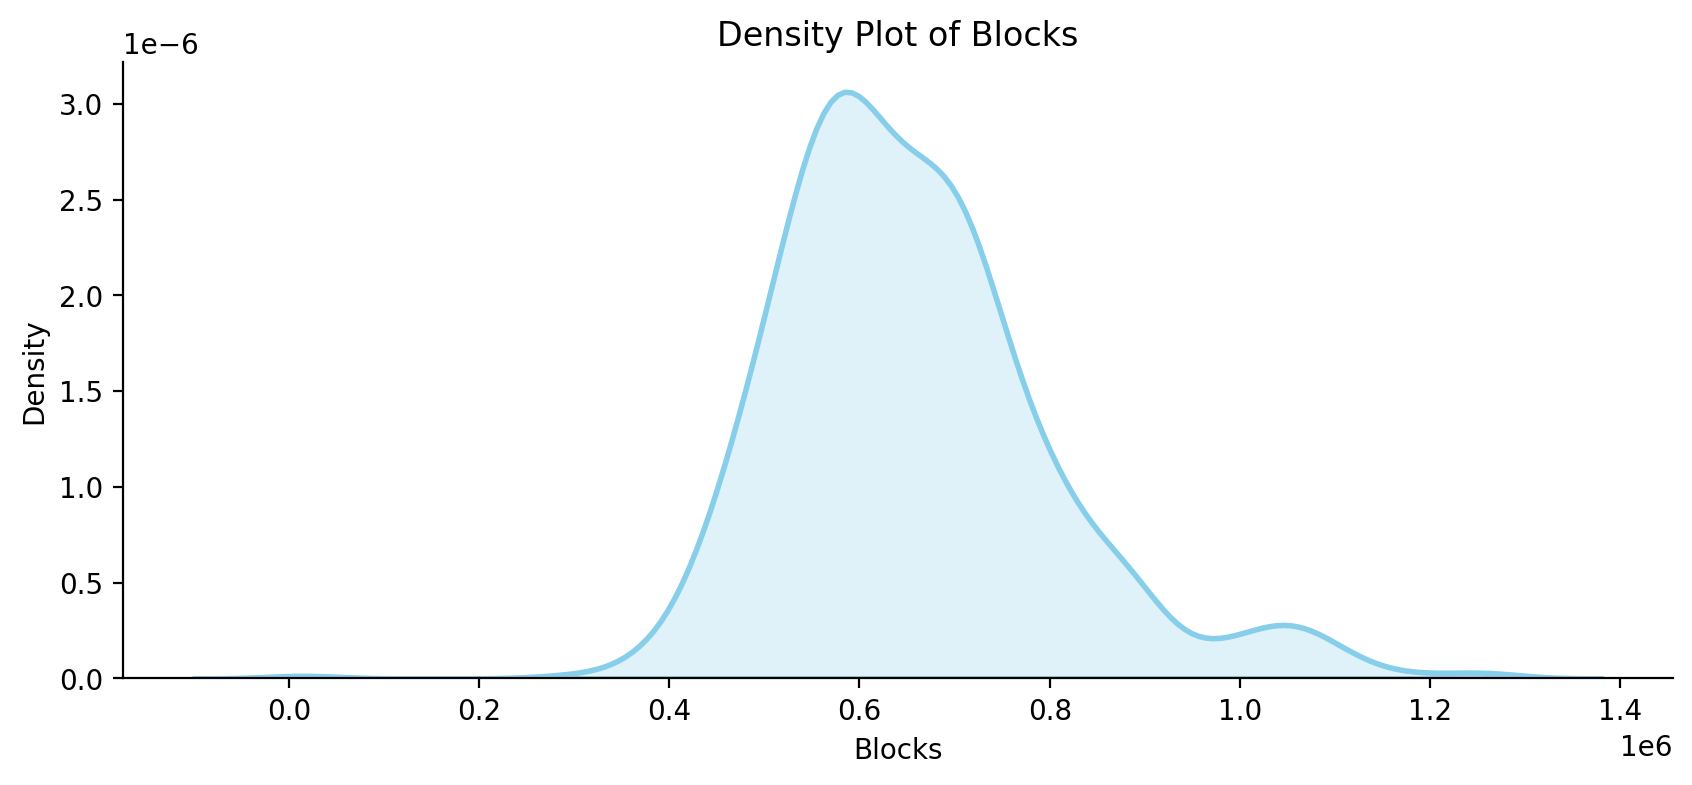

In [4]:
plt.figure(figsize=(10, 4))  # Adjust the figure size

sns.kdeplot(finalDataset['Blocks'], color='skyblue', linewidth=2, fill=True)

plt.xlabel('Blocks')  # Add x-axis label
plt.ylabel('Density')  # Add y-axis label
plt.title('Density Plot of Blocks')  # Add plot title

sns.despine()  # Remove the top and right spines

plt.show()

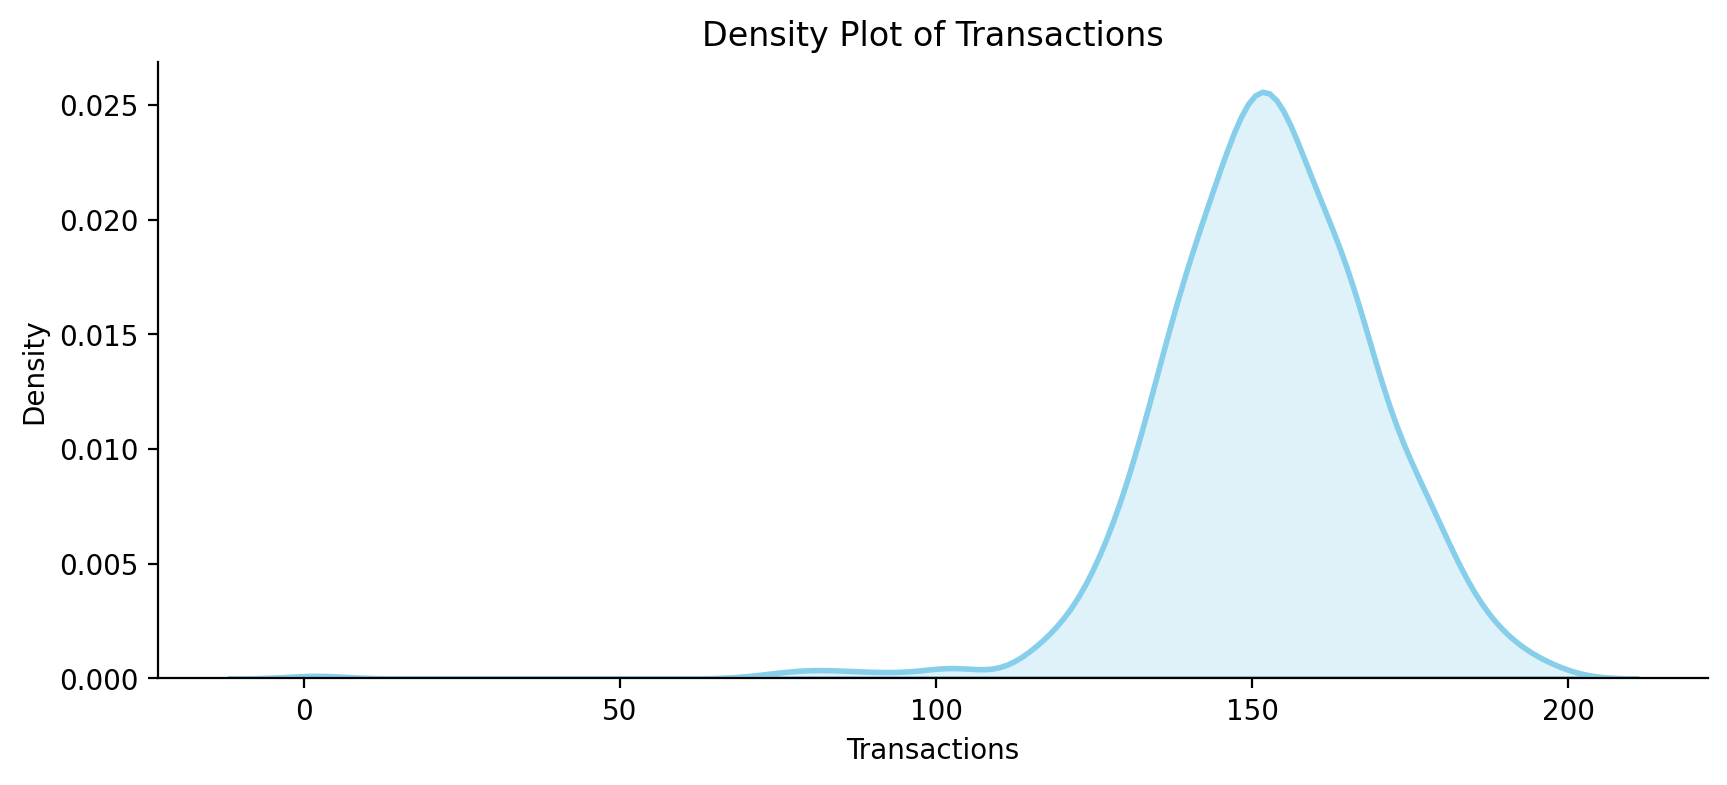

In [5]:
plt.figure(figsize=(10, 4))  # Adjust the figure size

sns.kdeplot(finalDataset['Transactions'], color='skyblue', linewidth=2, fill=True)

plt.xlabel('Transactions')  # Add x-axis label
plt.ylabel('Density')  # Add y-axis label
plt.title('Density Plot of Transactions')  # Add plot title

sns.despine()  # Remove the top and right spines

plt.show()

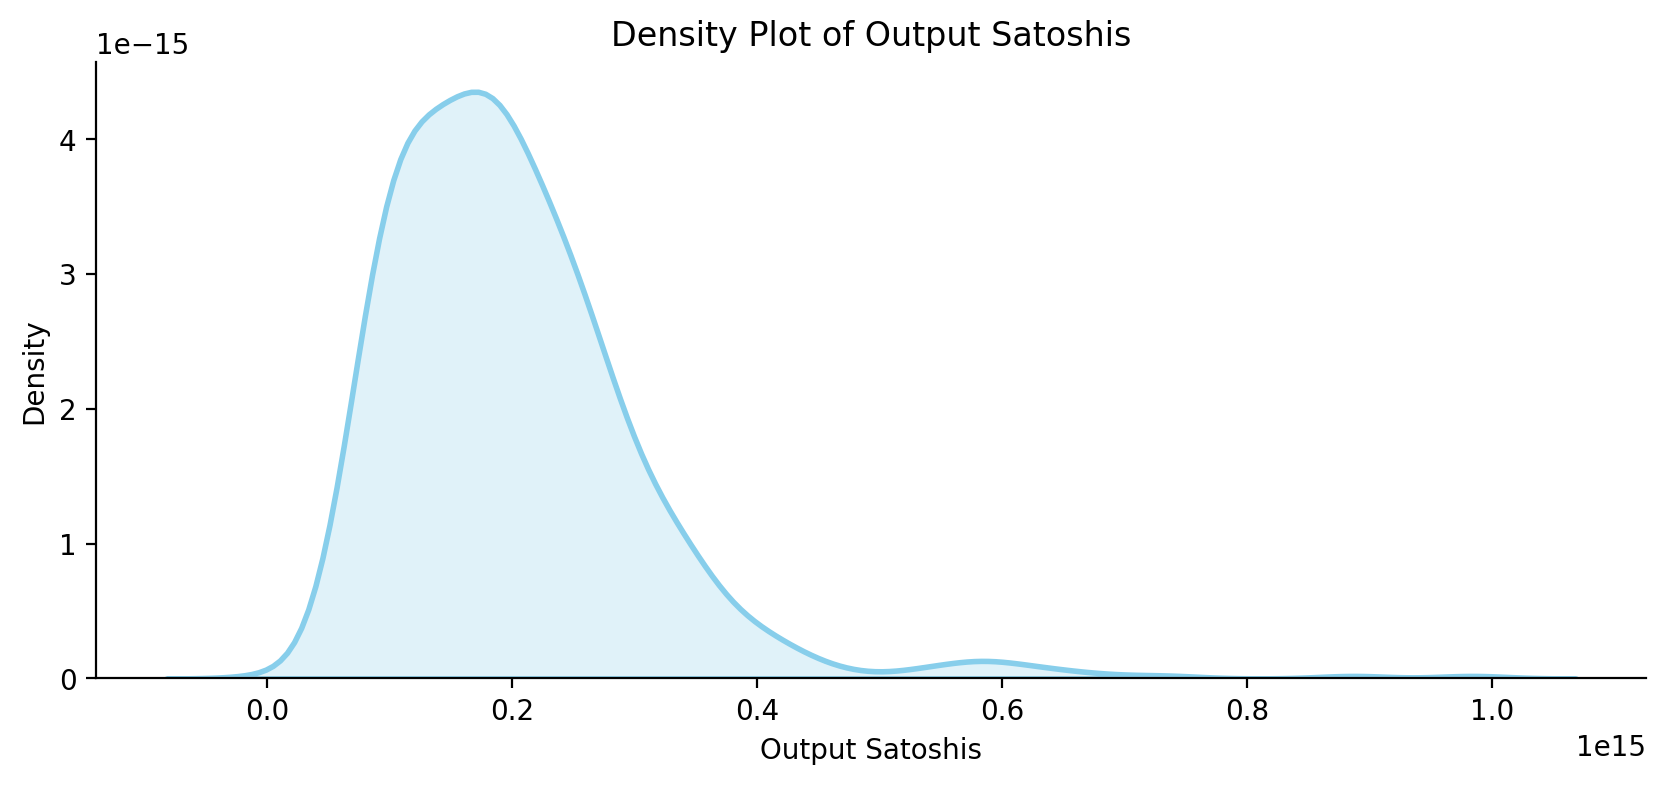

In [6]:
plt.figure(figsize=(10, 4))  # Adjust the figure size

sns.kdeplot(finalDataset['Output_Satoshis'], color='skyblue', linewidth=2, fill=True)

plt.xlabel('Output Satoshis')  # Add x-axis label
plt.ylabel('Density')  # Add y-axis label
plt.title('Density Plot of Output Satoshis')  # Add plot title

sns.despine()  # Remove the top and right spines

plt.show()

<Figure size 1000x400 with 0 Axes>

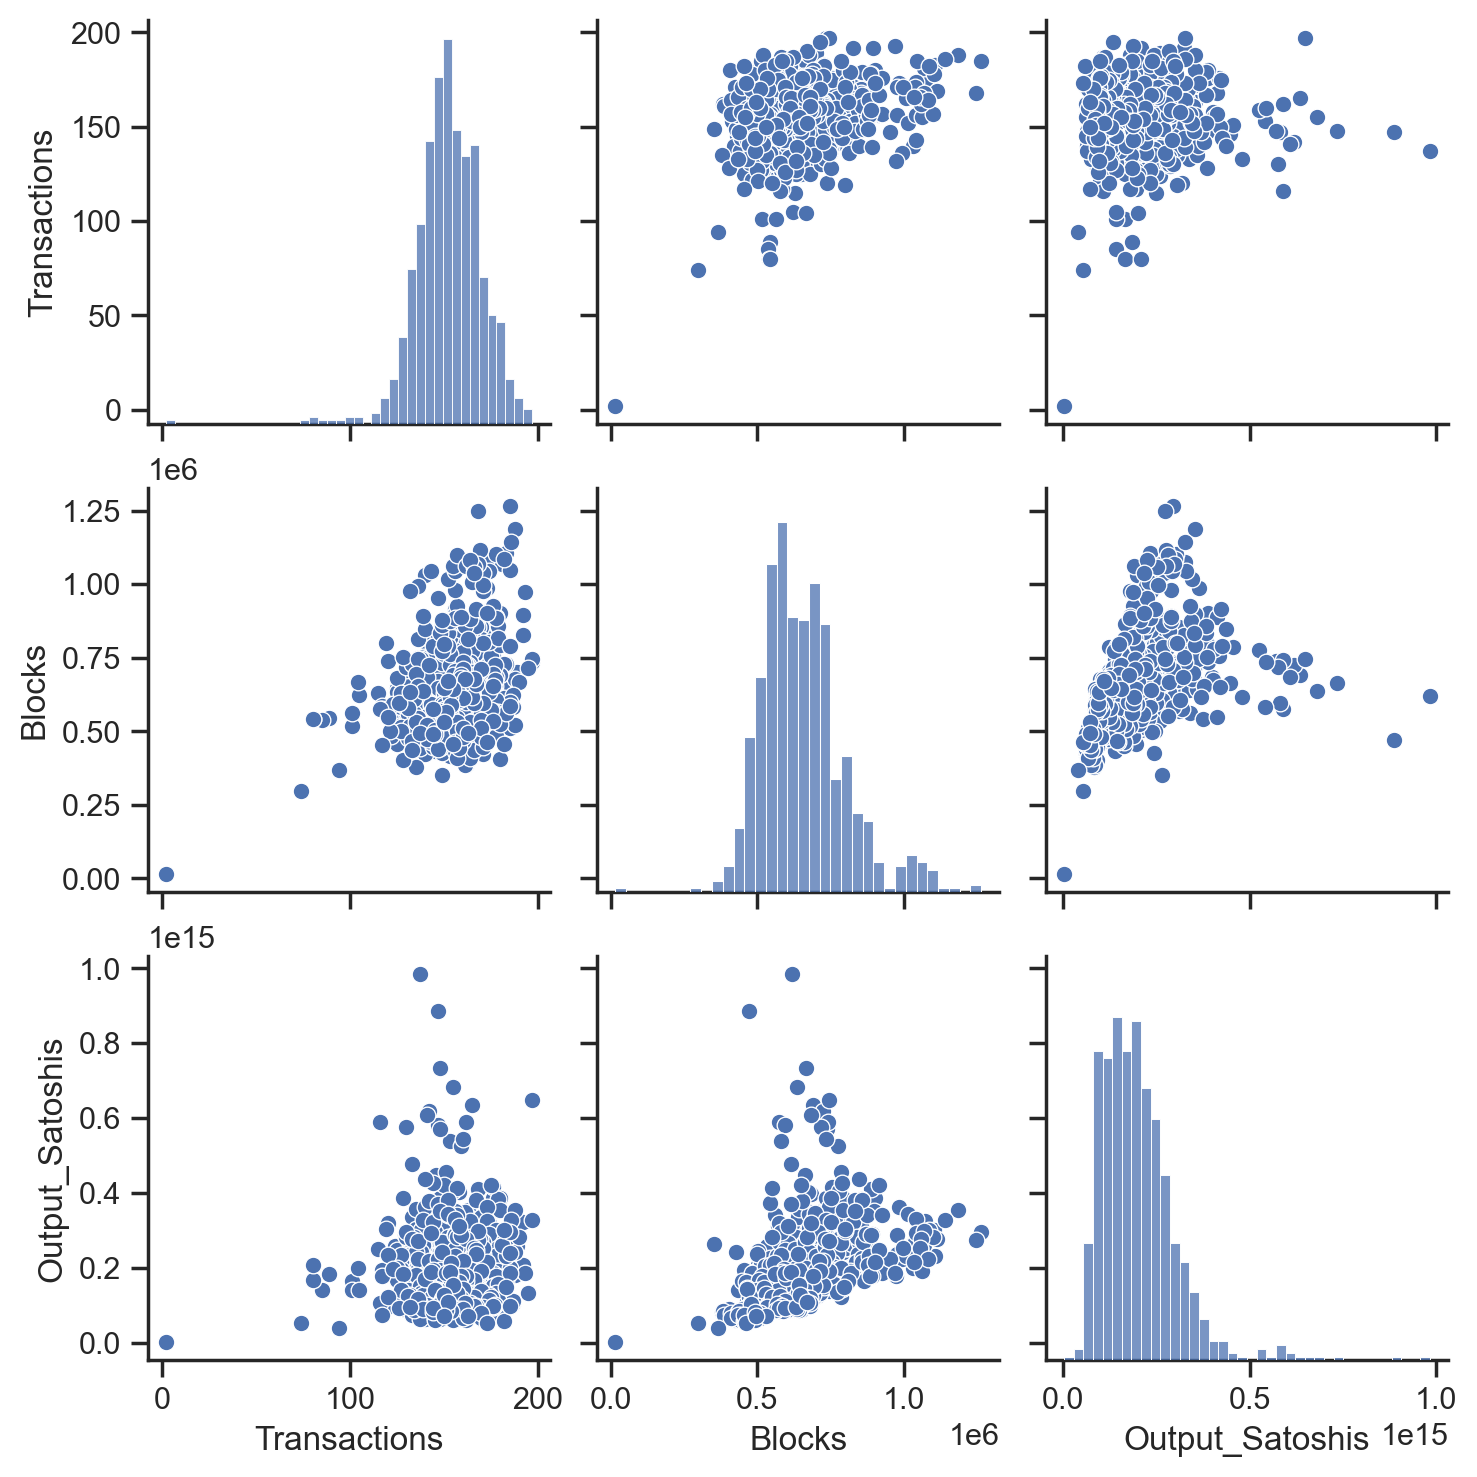

In [7]:
sns.set(style="ticks");
plt.figure(figsize=(10, 4)) 
sns.pairplot(finalDataset);

## Model Building & Evaluation 

### 1. Isolation Forest

In [8]:
data = finalDataset[['Output_Satoshis','Blocks','Transactions']]
outliers_fraction = 0.15
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data) 

IsolationForest(contamination=0.15)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.92, 'Transactions vs Blocks vs Sum of Output Satoshis: Red represents Anomalies')

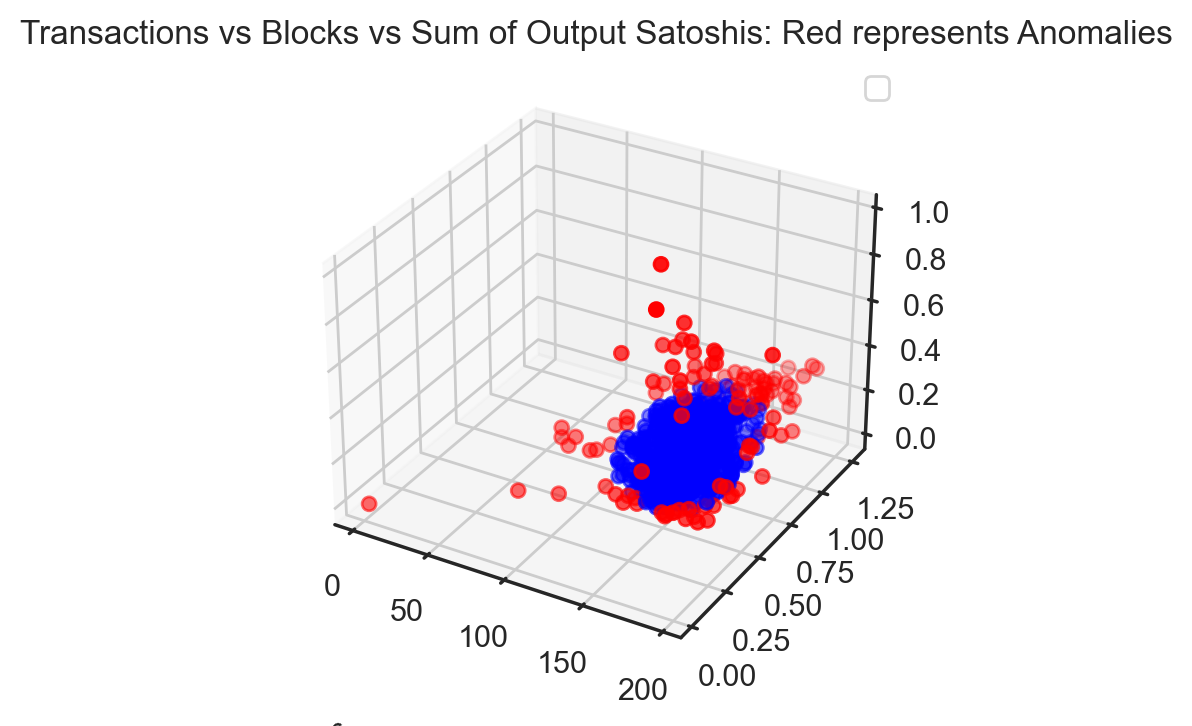

In [9]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111,projection='3d')
X = finalDataset.iloc[:,1:4].values
colors = np.array(['red', 'blue'])
y_pred = model.fit_predict(data)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=25, color=colors[(y_pred + 1) // 2] )
ax.legend();
plt.title('Transactions vs Blocks vs Sum of Output Satoshis: Red represents Anomalies')
## plt.savefig('IsolationForest_anomaly.png', dpi=1000)

In [10]:
finalDataset['anomaly_IsolationForest'] = pd.Series(model.predict(data))
finalDataset['anomaly_IsolationForest'] = finalDataset['anomaly_IsolationForest'].apply(lambda x: x == -1)
finalDataset['anomaly_IsolationForest'] = finalDataset['anomaly_IsolationForest'].astype(int)

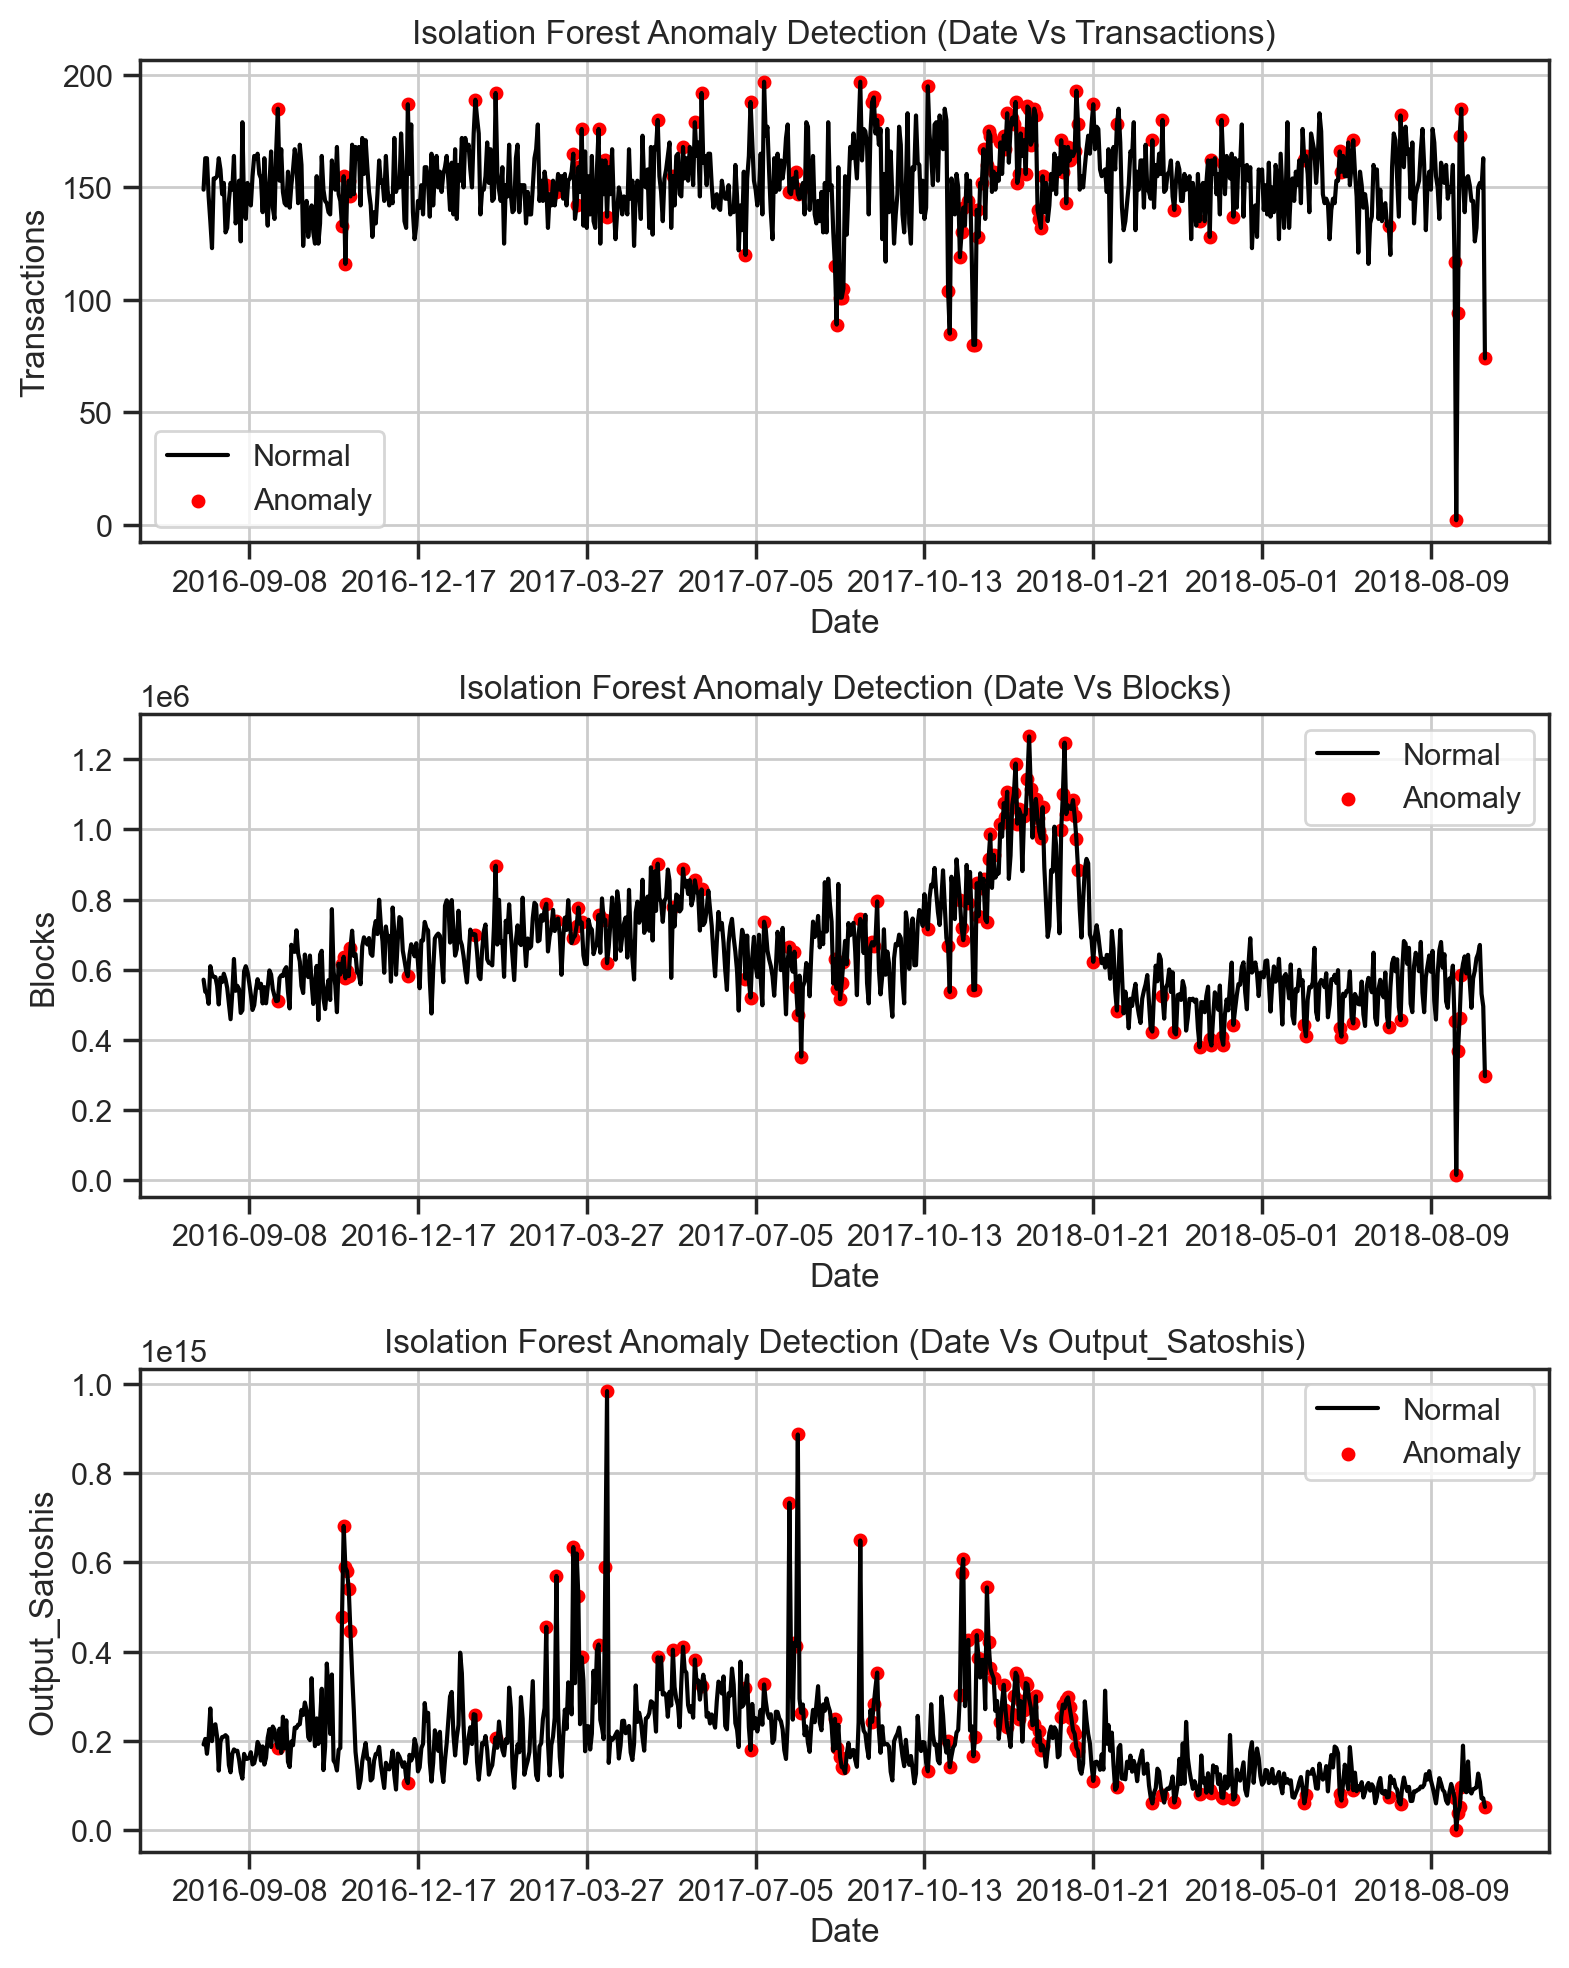

In [11]:
import matplotlib.dates as mdates
# Convert 'Date' column to datetime format
finalDataset['Date'] = pd.to_datetime(finalDataset['Date'])

fig, ax = plt.subplots(3, 1, figsize=(8, 10))  # Adjust the figsize as needed

variables = ['Transactions', 'Blocks', 'Output_Satoshis']

for i, variable in enumerate(variables):
    a = finalDataset.loc[finalDataset['anomaly_IsolationForest'] == 1]
    ax[i].plot(finalDataset['Date'], finalDataset[variable], color='black', label='Normal', linewidth=1.5)
    ax[i].scatter(a['Date'], a[variable], color='red', label='Anomaly', s=16)
    ax[i].legend()
    ax[i].set_title("Isolation Forest Anomaly Detection (" + "Date Vs " + variable + ")")
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel(variable)
    ax[i].grid(True)
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the x-axis as 'YYYY-MM-DD'
    ax[i].xaxis.set_major_locator(mdates.DayLocator(interval=100))  # Show every 30 days

plt.tight_layout()
plt.savefig('IsolationForest.png')
plt.show()

In [13]:
# Predict anomalies
predictions = model.predict(data)

# Convert predictions to DataFrame
anomaly_df = pd.DataFrame({'anomaly': predictions})

# Add the original features to the DataFrame
anomaly_df = pd.concat([data, anomaly_df], axis=1)

# Calculate F1-score
true_labels = anomaly_df['anomaly'] == 1  # Anomalies are represented by 1, normal data by -1
predicted_labels = anomaly_df['anomaly']

report_isolationForest = classification_report(true_labels, predicted_labels)
print("F1-score:", report_isolationForest)

F1-score:               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00       114
           1       1.00      1.00      1.00       646

    accuracy                           0.85       760
   macro avg       0.33      0.33      0.33       760
weighted avg       0.85      0.85      0.85       760



## 2. K-Means

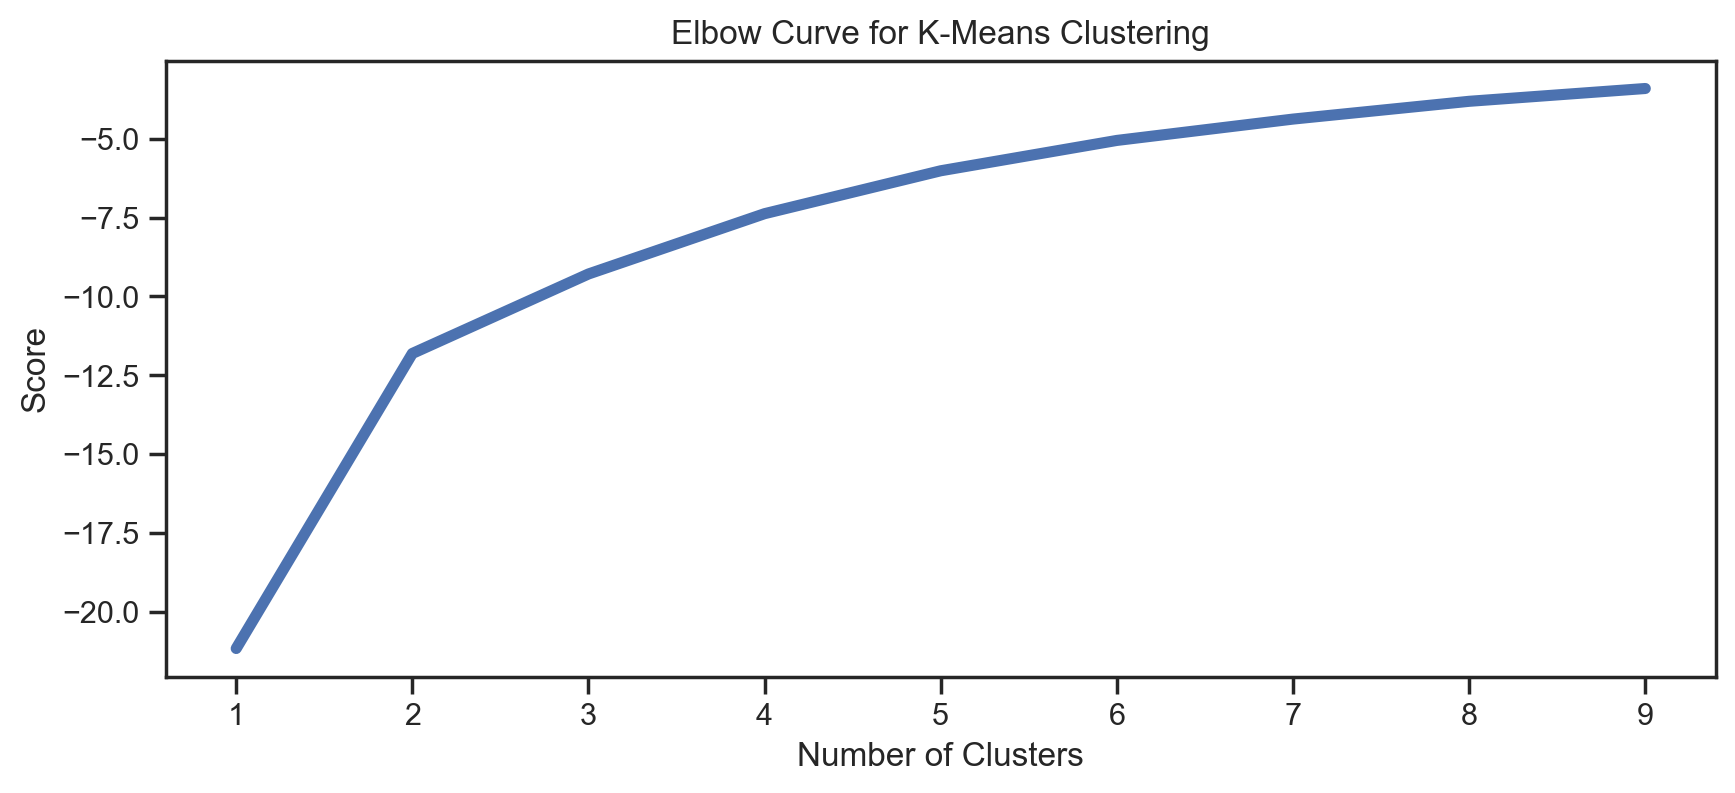

In [14]:
data = MinMaxScaler().fit_transform(data)
pca = PCA(n_components=2) # we have selected 2 components in PCA for simplicity
pca.fit(data)
reduced_data = pca.transform(data)
reduced_data = pd.DataFrame(reduced_data)

num_clusters = range(1, 10)

kmeans = [KMeans(n_clusters=i, random_state=seed).fit(reduced_data) for i in num_clusters]
scores = [kmeans[i].score(reduced_data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(num_clusters, scores, linewidth = 4)
plt.xticks(num_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve for K-Means Clustering')
plt.savefig('elbow_effect.png', dpi = 1000)
plt.show();

In [15]:
#Choosing the three clusters based on the elbow curve
optimal_Clusters = 3
km_3 = KMeans(n_clusters=optimal_Clusters, random_state=seed)
km_3.fit(reduced_data)
km_3.predict(reduced_data)
labels_3 = km_3.labels_

#Choosing the four clusters based on the elbow curve
optimal_Clusters = 4
km_4 = KMeans(n_clusters=optimal_Clusters, random_state=seed)
km_4.fit(reduced_data)
km_4.predict(reduced_data)
labels_4 = km_4.labels_

#Choosing the five clusters based on the elbow curve
optimal_Clusters = 5
km_5 = KMeans(n_clusters=optimal_Clusters, random_state=seed)
km_5.fit(reduced_data)
km_5.predict(reduced_data)
labels_5 = km_5.labels_

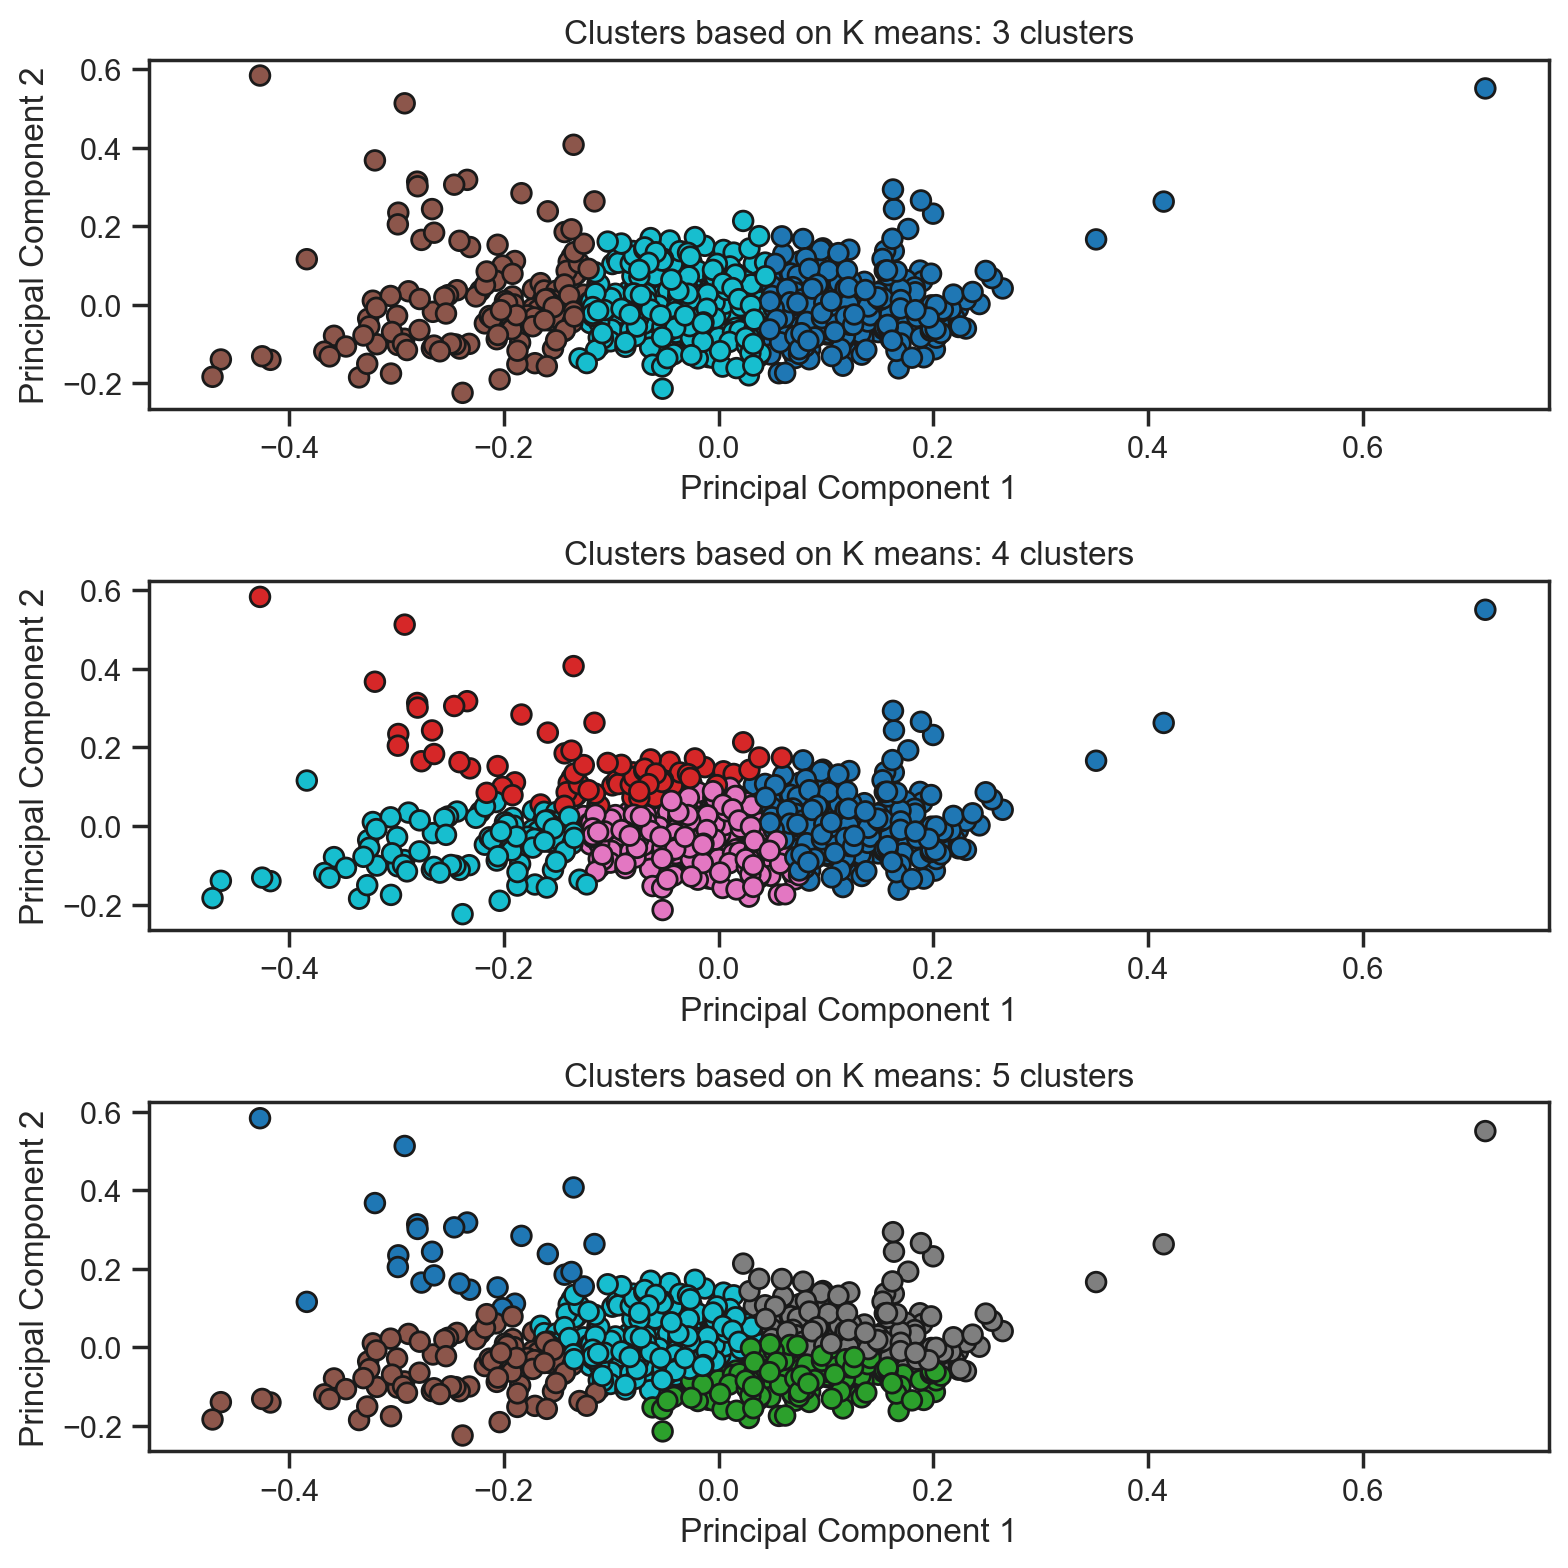

In [16]:
# Create a color map with unique colors for each cluster
cmap = plt.cm.get_cmap('tab10')

# Plot all clusters together in rows and columns
plt.figure(figsize=(8, 8))

# Plot for 3 clusters
plt.subplot(3, 1, 1)
plt.scatter(reduced_data.iloc[:, 0], reduced_data.iloc[:, 1], 
            c=labels_3.astype(np.float), cmap=cmap, edgecolor="k", s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters based on K means: 3 clusters')

# Plot for 4 clusters
plt.subplot(3, 1, 2)
plt.scatter(reduced_data.iloc[:, 0], reduced_data.iloc[:, 1], 
            c=labels_4.astype(np.float), cmap=cmap, edgecolor="k", s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters based on K means: 4 clusters')

# Plot for 5 clusters
plt.subplot(3, 1, 3)
plt.scatter(reduced_data.iloc[:, 0], reduced_data.iloc[:, 1], 
            c=labels_5.astype(np.float), cmap=cmap, edgecolor="k", s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters based on K means: 5 clusters')
plt.tight_layout()
plt.savefig('clustering_analysis.png', dpi = 1000)
plt.show()

The best finalDatasets were drawn with a plot with four clusters. So, we will proceed further by considering four clusters for the problem.

In [17]:
reduced_data['Principal Component 1'] = reduced_data[0]
reduced_data['Principal Component 2'] = reduced_data[1]
reduced_data.drop(columns = [0, 1], inplace=True)
reduced_data.head()

Principal Component 1  Principal Component 2
0               0.061595               0.023953
1               0.056037              -0.011928
2               0.078372              -0.033201
3               0.098505               0.059304
4               0.008486               0.120800

In [18]:
def getDistanceByPoint(data, model):
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return distance

In [19]:
outliers_fraction = 0.15

# find the distance between each point and its nearest centroid. The largest distances will be consdiered anomalies
distance = getDistanceByPoint(reduced_data, kmeans[optimal_Clusters-1])

distance = pd.Series(distance)
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()

# anomaly_kmeans contain the anomaly finalDataset of the above method  (0:normal, 1:anomaly) 
finalDataset['anomaly_kmeans'] = (distance >= threshold).astype(int)

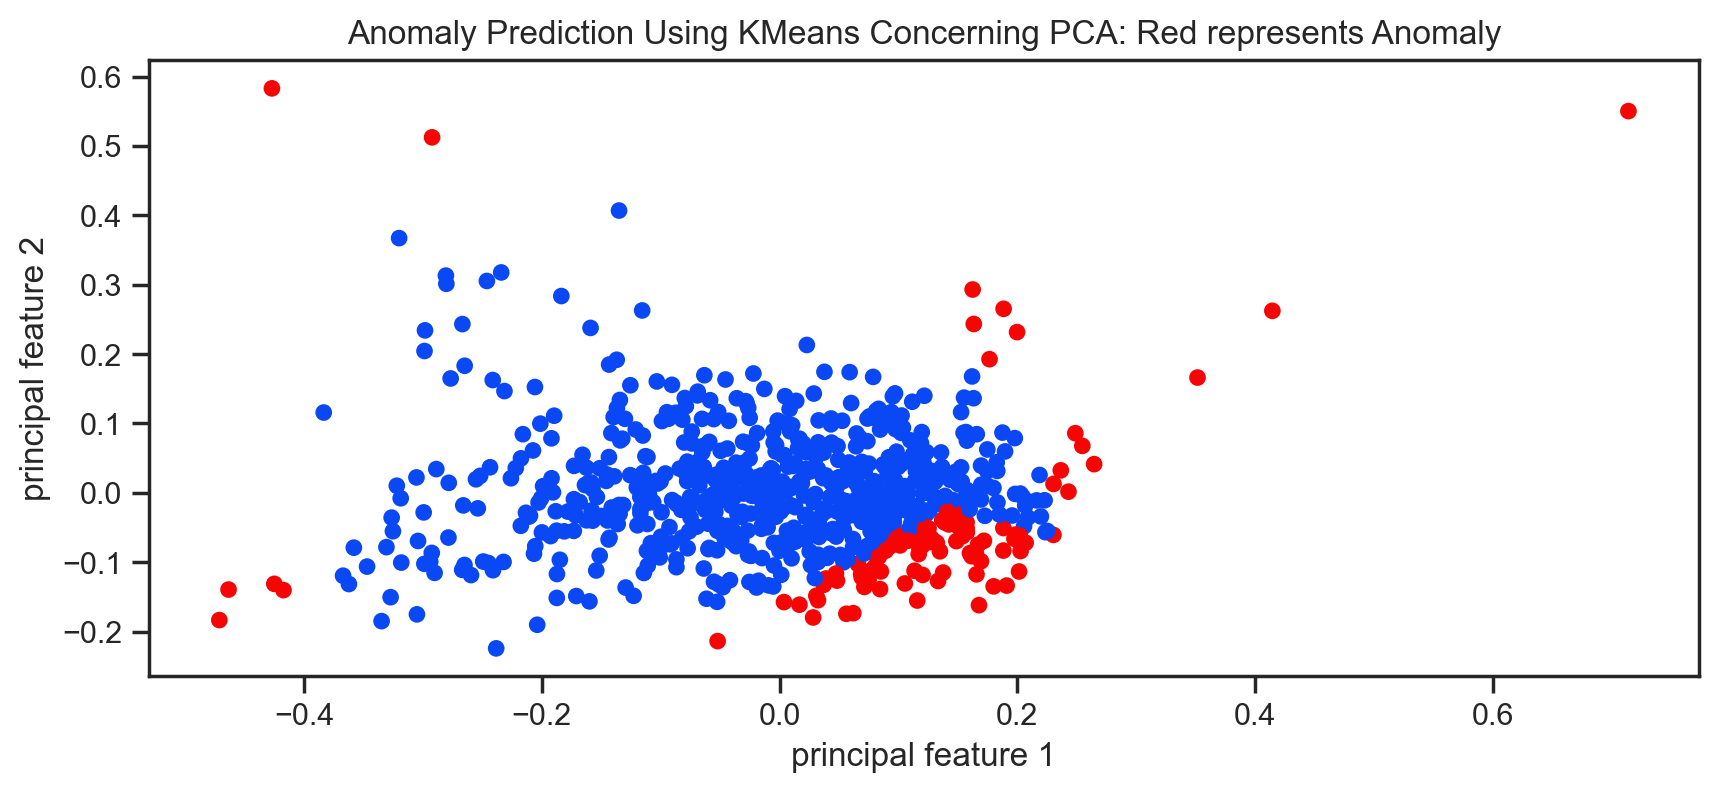

In [20]:
# visualisation of anomaly with cluster view
colors = {1:'#f70505', 0:'#0a48f5'}

plt.figure(figsize=(10,4))
plt.scatter(reduced_data.iloc[:,0], reduced_data.iloc[:,1], 
            c=finalDataset["anomaly_kmeans"].apply(lambda x: colors[x]), s=25)

plt.xlabel('principal feature 1')
plt.ylabel('principal feature 2')
plt.title('Anomaly Prediction Using KMeans Concerning PCA: Red represents Anomaly')
plt.savefig('KMeans_PCA_Anomaly.png', dpi=1000)

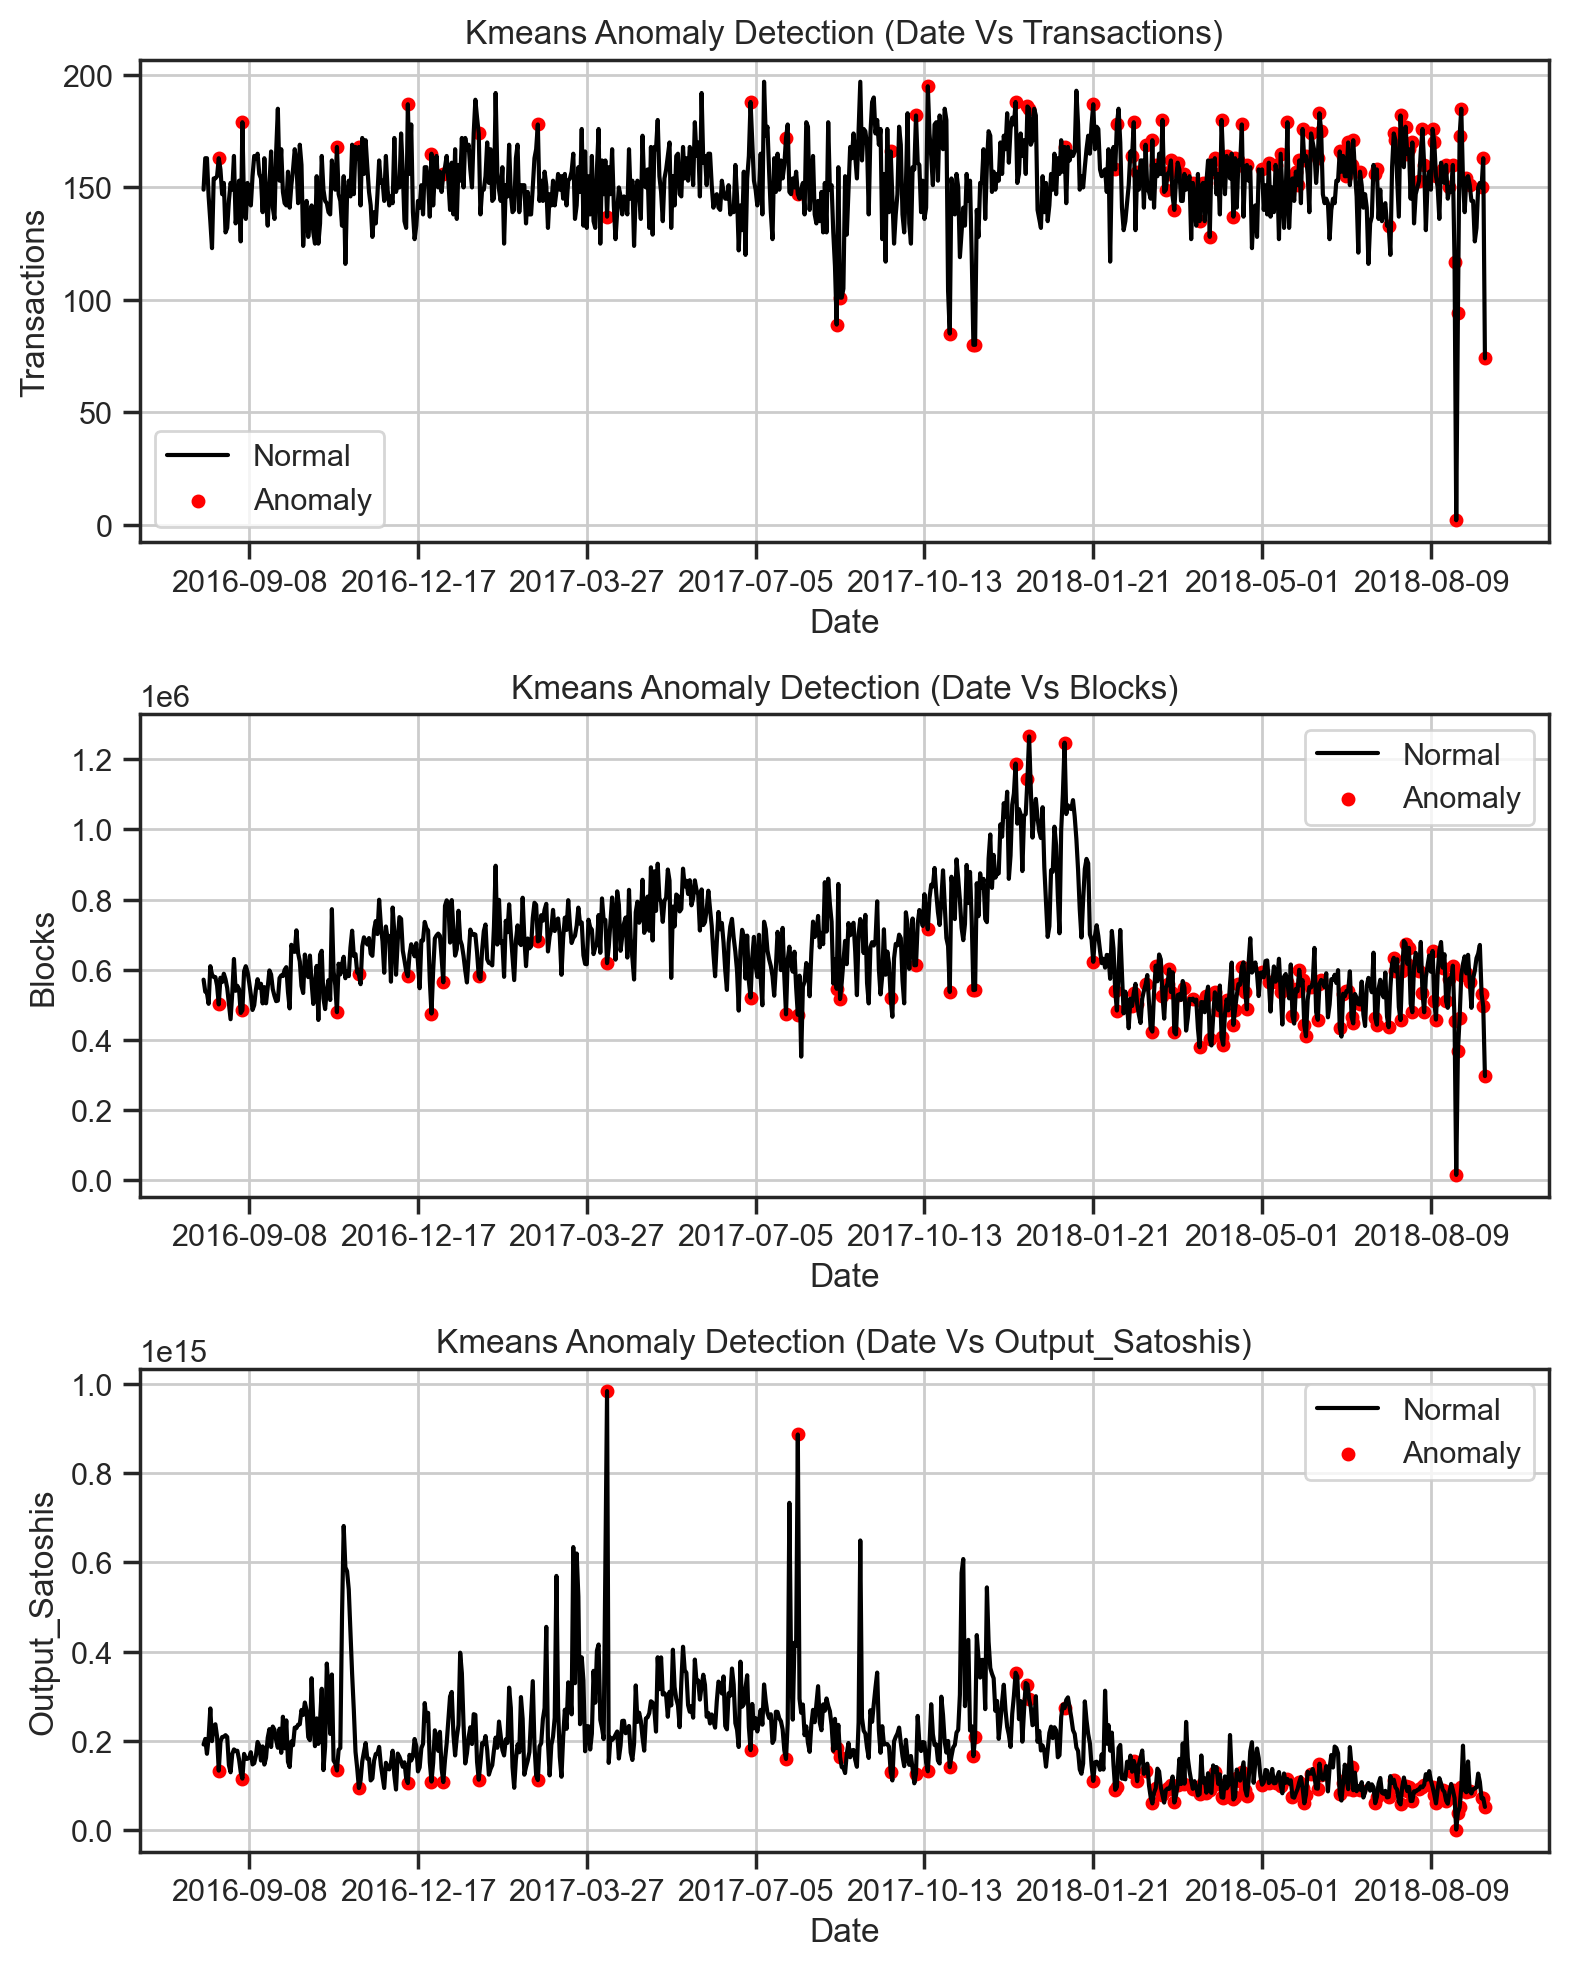

In [21]:
finalDataset['Date'] = pd.to_datetime(finalDataset['Date'])

fig, ax = plt.subplots(3, 1, figsize=(8, 10))  # Adjust the figsize as needed

variables = ['Transactions', 'Blocks', 'Output_Satoshis']

for i, variable in enumerate(variables):
    a = finalDataset.loc[finalDataset['anomaly_kmeans'] == 1]
    ax[i].plot(finalDataset['Date'], finalDataset[variable], color='black', label='Normal', linewidth=1.5)
    ax[i].scatter(a['Date'], a[variable], color='red', label='Anomaly', s=16)
    ax[i].legend()
    ax[i].set_title("Kmeans Anomaly Detection (" + "Date Vs " + variable + ")")
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel(variable)
    ax[i].grid(True)
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the x-axis as 'YYYY-MM-DD'
    ax[i].xaxis.set_major_locator(mdates.DayLocator(interval=100))  # Show every 30 days

plt.tight_layout()
plt.savefig('Kmeans_Anomaly.png')
plt.show()

In [22]:
finalDataset['anomaly_kmeans'].value_counts()

0    646
1    114
Name: anomaly_kmeans, dtype: int64

In [23]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score

km_4 = KMeans(n_clusters=optimal_Clusters, random_state=seed)
km_4.fit(data)
predicted_labels = km_4.predict(data)

# Inertia or Sum of Squared Errors (SSE)
inertia = km_4.inertia_

# Silhouette Score
silhouette = silhouette_score(data, predicted_labels)

# Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(data, predicted_labels)

# Assuming you have the true labels for the data
true_labels = finalDataset['anomaly_kmeans'] == 1 

# Adjusted Rand Index (ARI)
ari = adjusted_rand_score(true_labels, predicted_labels)

# Normalized Mutual Information (NMI)
nmi = normalized_mutual_info_score(true_labels, predicted_labels)

print("Inertia: {:.4f}".format(inertia))
print("Silhouette Score: {:.4f}".format(silhouette))
print("Davies-Bouldin Index: {:.4f}".format(davies_bouldin))
print("Adjusted Rand Index (ARI): {:.4f}".format(ari))
print("Normalized Mutual Information (NMI): {:.4f}".format(nmi))

Inertia: 8.8547
Silhouette Score: 0.2803
Davies-Bouldin Index: 1.0210
Adjusted Rand Index (ARI): 0.0405
Normalized Mutual Information (NMI): 0.1324


### AutoEncoder

In [24]:
data = finalDataset[['Transactions', 'Blocks', 'Output_Satoshis']].values

# Normalize the data
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)

In [25]:
# Split the data into train and test sets
train_data, test_data = train_test_split(normalized_data, test_size=0.2, random_state=42)

In [26]:
# Define the autoencoder model
input_dim = train_data.shape[1]
encoding_dim = 2  # Number of neurons in the hidden layer (you can adjust this)
input_layer = tensorflow.keras.Input(shape=(input_dim,))
encoder = tensorflow.keras.layers.Dense(encoding_dim, activation='relu')(input_layer)
decoder = tensorflow.keras.layers.Dense(input_dim, activation='sigmoid')(encoder)
autoencoder = tensorflow.keras.Model(inputs=input_layer, outputs=decoder)

In [27]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(train_data, train_data, epochs=100, batch_size=32, shuffle=True, validation_data=(test_data, test_data))

Epoch 1/100
19/19 [==============================] - 1s 17ms/step - loss: 0.0645 - val_loss: 0.0622
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0627 - val_loss: 0.0604
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0609 - val_loss: 0.0587
Epoch 4/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0592 - val_loss: 0.0571
Epoch 5/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0576 - val_loss: 0.0554
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0560 - val_loss: 0.0539
Epoch 7/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0545 - val_loss: 0.0524
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0530 - val_loss: 0.0509
Epoch 9/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0515 - val_loss: 0.0495
Epoch 10/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0501 - val_loss: 0.0481
Epoch 11

In [28]:
# Reconstruct the data using the trained autoencoder
reconstructed_data = autoencoder.predict(normalized_data)

24/24 [==============================] - 0s 2ms/step


In [29]:
# Calculate the reconstruction errors
mse = np.mean(np.power(normalized_data - reconstructed_data, 2), axis=1)

In [30]:
# You can adjust the multiplier for the standard deviation
threshold = np.mean(mse) + 0.3 * np.std(mse)  

# Identify anomalies
anomaly_indices = np.where(mse > threshold)[0]
finalDataset['anomaly_autoencoder'] = 0  
finalDataset.loc[anomaly_indices, 'anomaly_autoencoder'] = 1 

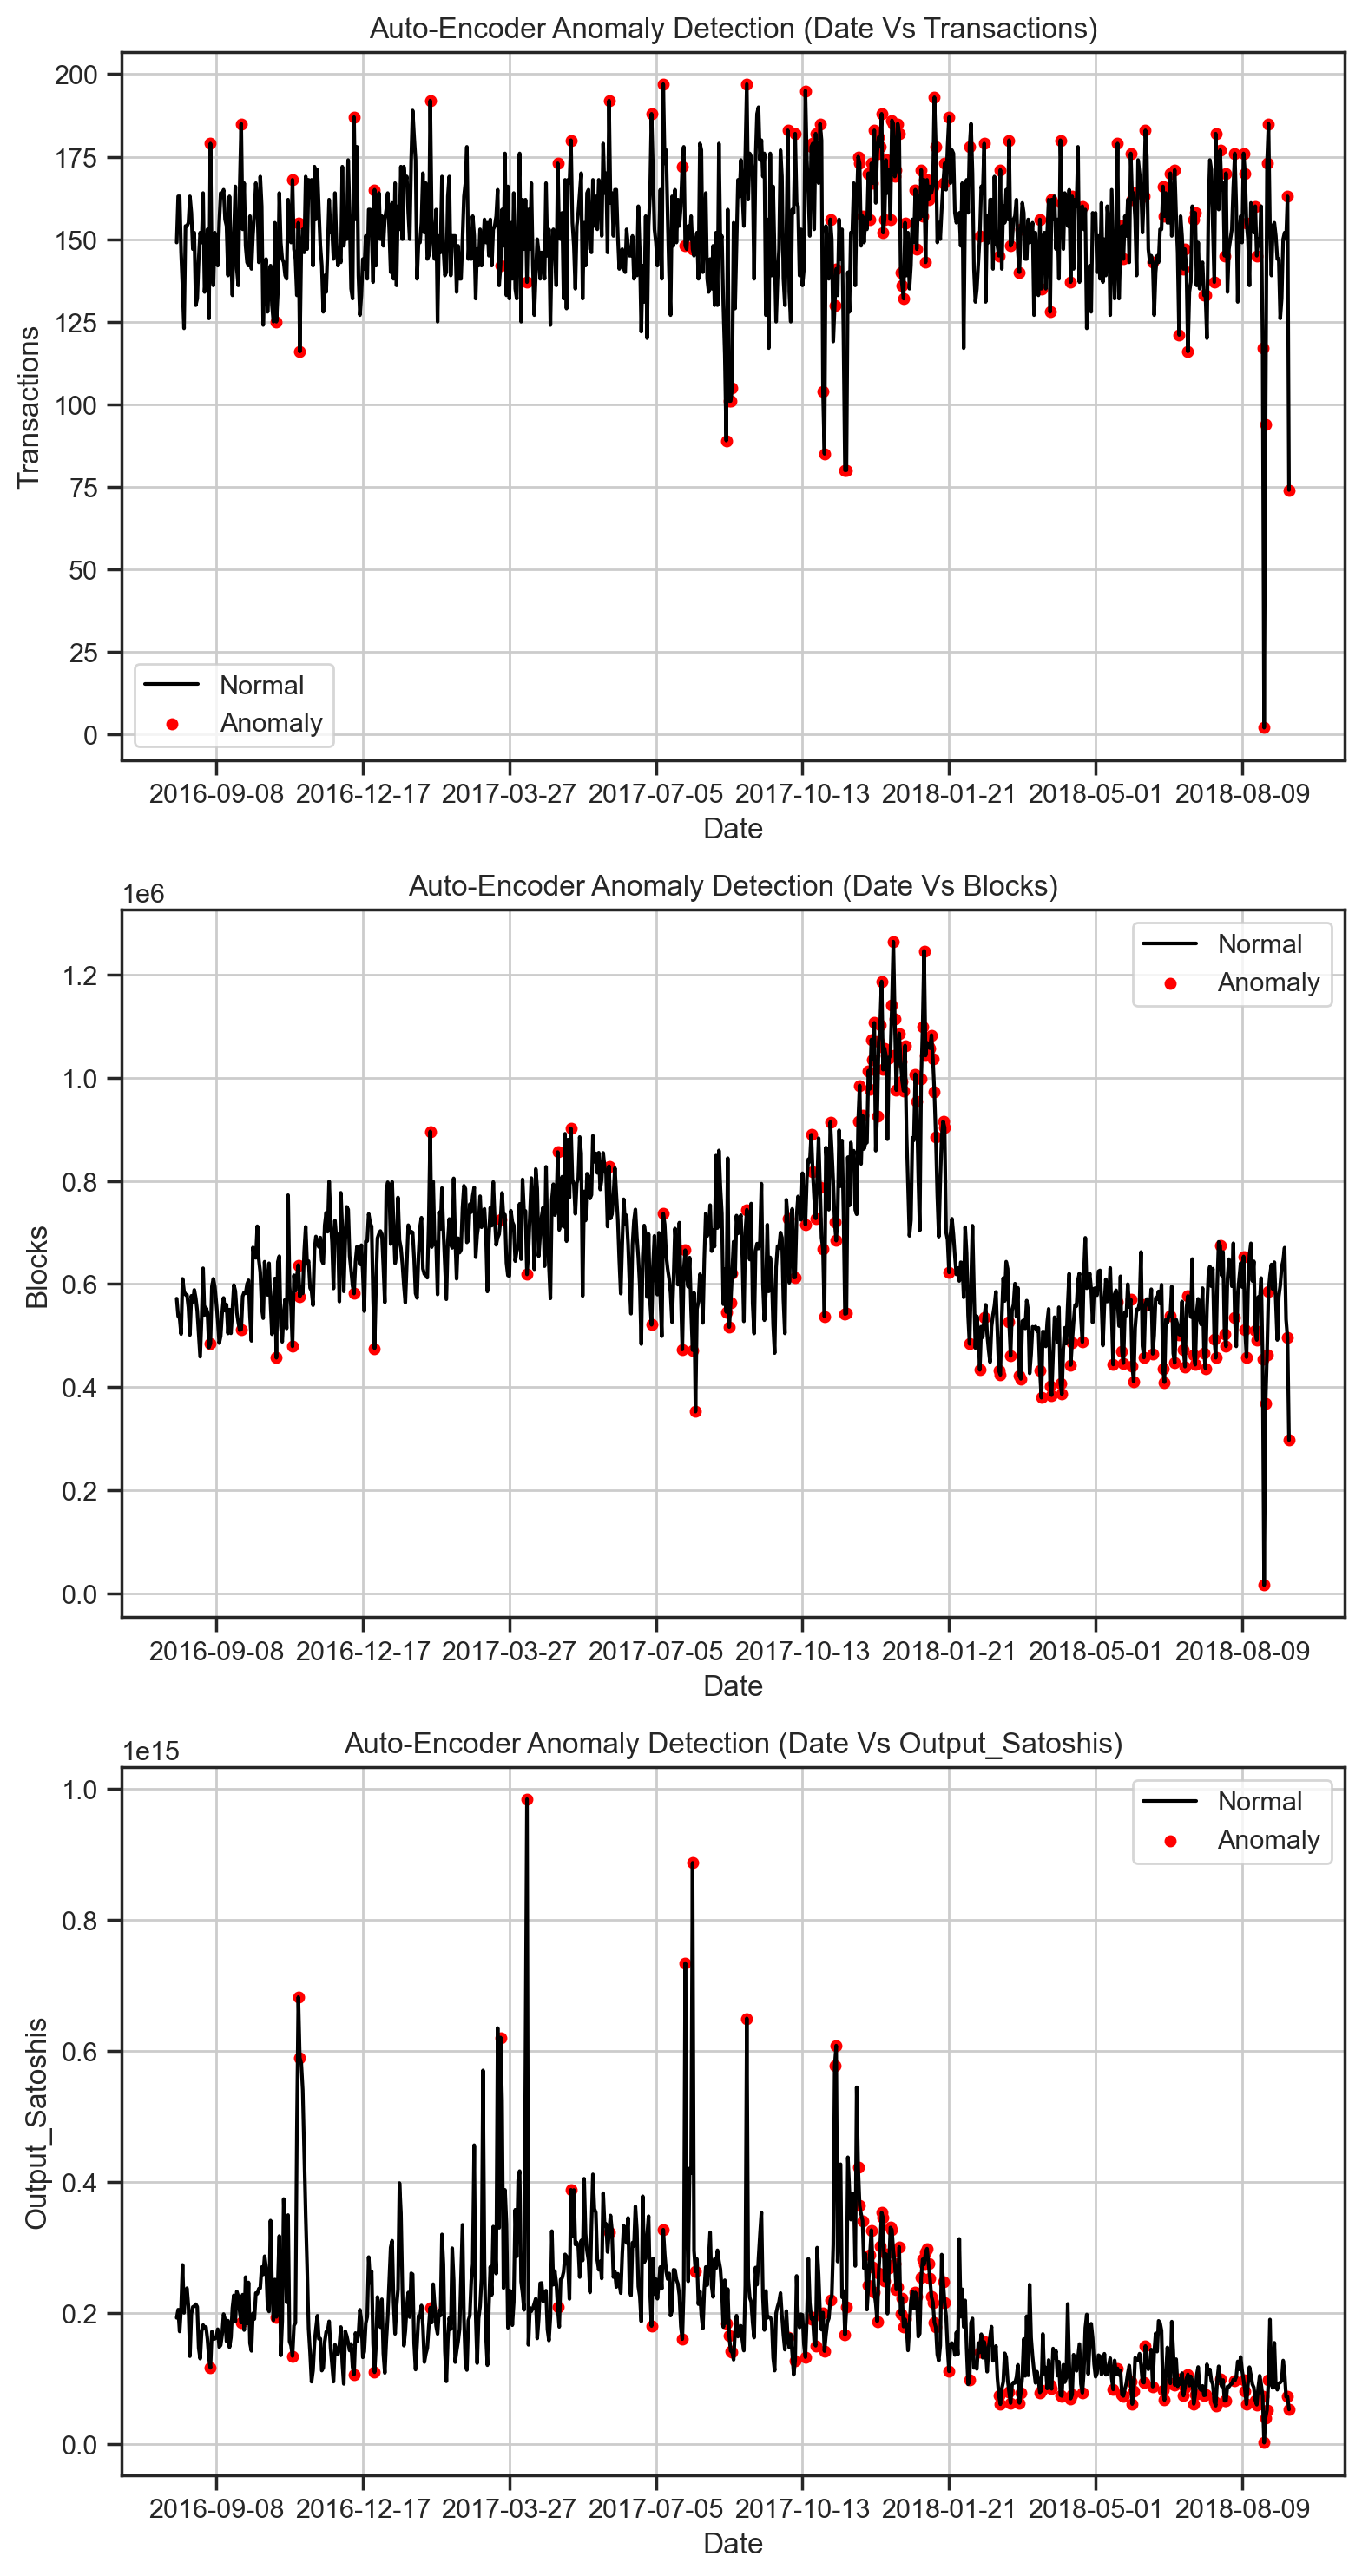

In [32]:
# Convert 'Date' column to datetime format
finalDataset['Date'] = pd.to_datetime(finalDataset['Date'])

fig, ax = plt.subplots(3, 1, figsize=(8, 15))  # Adjust the figsize as needed

variables = ['Transactions', 'Blocks', 'Output_Satoshis']

for i, variable in enumerate(variables):
    a = finalDataset.loc[finalDataset['anomaly_autoencoder'] == 1]
    ax[i].plot(finalDataset['Date'], finalDataset[variable], color='black', label='Normal', linewidth=1.5)
    ax[i].scatter(a['Date'], a[variable], color='red', label='Anomaly', s=16)
    ax[i].legend()
    ax[i].set_title("Auto-Encoder Anomaly Detection (" + "Date Vs " + variable + ")")
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel(variable)
    ax[i].grid(True)
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the x-axis as 'YYYY-MM-DD'
    ax[i].xaxis.set_major_locator(mdates.DayLocator(interval=100))  # Show every 30 days

plt.tight_layout()
plt.savefig('auto_anomalies.png')
plt.show()

In [33]:
finalDataset['anomaly_autoencoder'].value_counts()

0    620
1    140
Name: anomaly_autoencoder, dtype: int64

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(normalized_data, reconstructed_data)

mae = mean_absolute_error(normalized_data, reconstructed_data)

print("Mean Squared Error (MSE): {:.4f}".format(mse))
print("Mean Absolute Error (MAE): {:.4f}".format(mae))

Mean Squared Error (MSE): 0.0099
Mean Absolute Error (MAE): 0.0774


## 4. GaussianMixture

In [35]:
data = finalDataset[['Transactions', 'Blocks', 'Output_Satoshis']].values

# Standardize the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(data)

In [36]:
# Train the Gaussian Mixture Model
gmm = GaussianMixture(n_components = 12) 
gmm.fit(standardized_data)

GaussianMixture(n_components=12)

In [37]:
# Predict the probabilities of the data points
probabilities = gmm.score_samples(standardized_data)
threshold = probabilities.mean() - 0.5 * probabilities.std()  

In [38]:
# Identify anomalies
anomaly_indices = finalDataset.index[probabilities < threshold]
finalDataset['anomaly_gaussian_Mixture'] = 0  
finalDataset.loc[anomaly_indices, 'anomaly_gaussian_Mixture'] = 1 

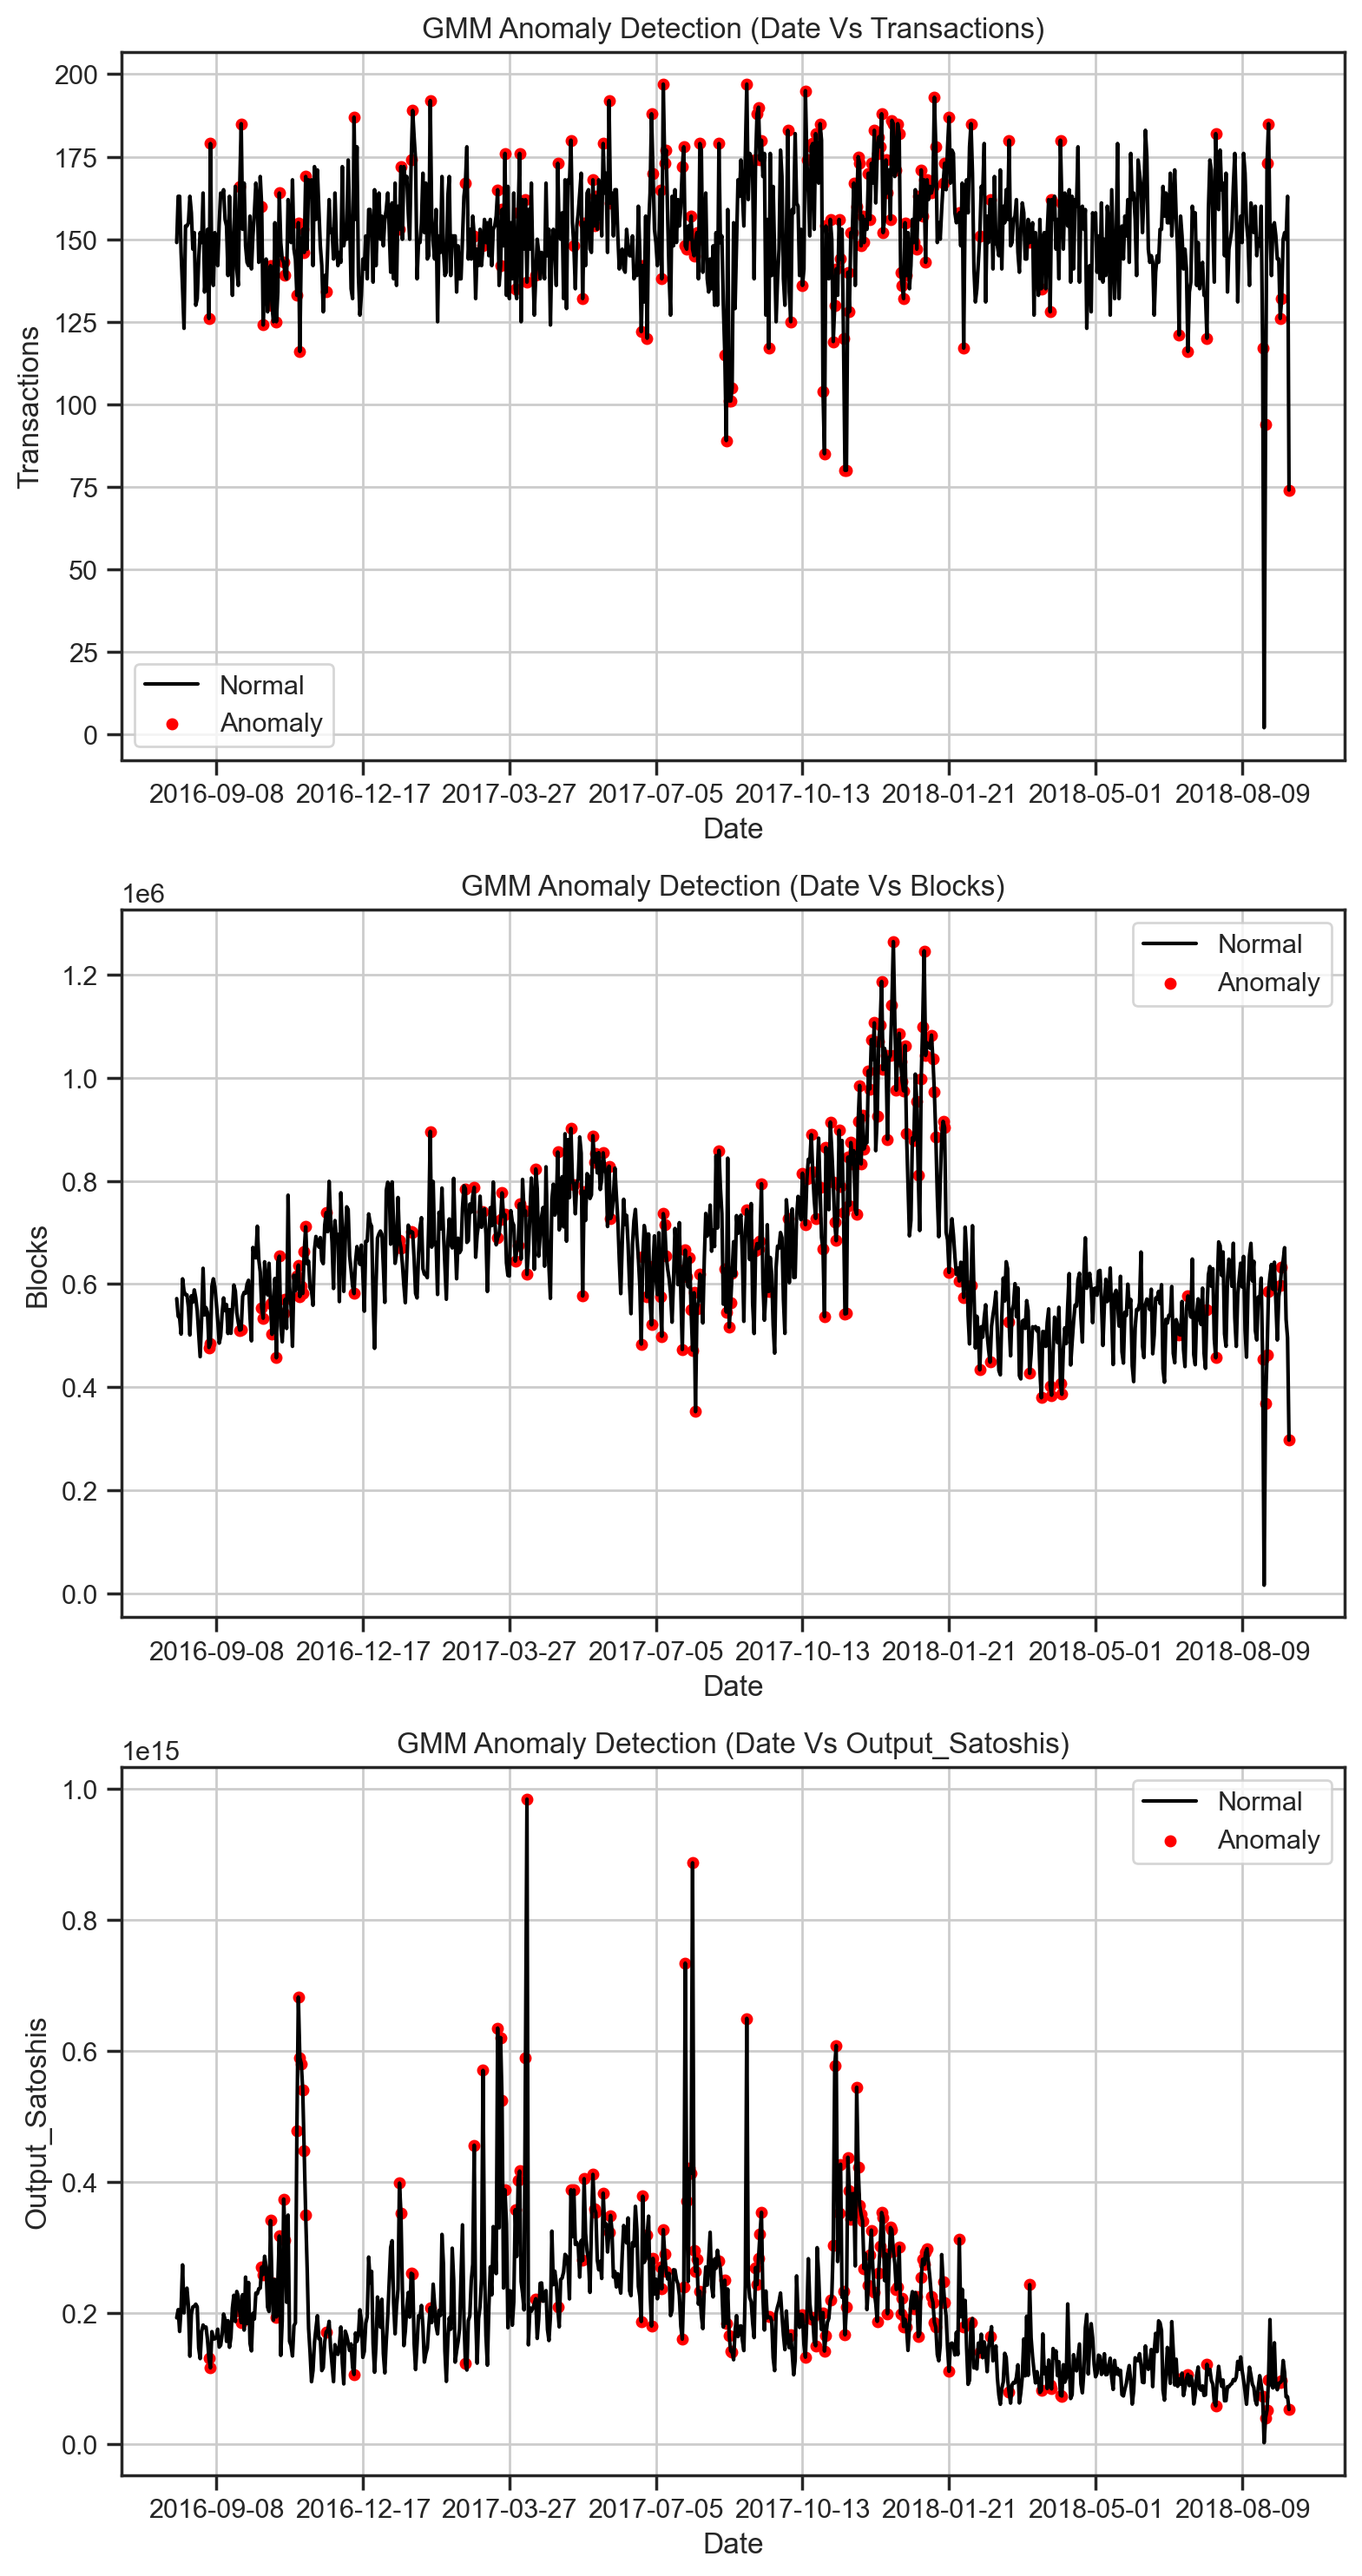

In [40]:
# Convert 'Date' column to datetime format
finalDataset['Date'] = pd.to_datetime(finalDataset['Date'])

fig, ax = plt.subplots(3, 1, figsize=(8, 15))  # Adjust the figsize as needed

variables = ['Transactions', 'Blocks', 'Output_Satoshis']

for i, variable in enumerate(variables):
    a = finalDataset.loc[finalDataset['anomaly_gaussian_Mixture'] == 1]
    ax[i].plot(finalDataset['Date'], finalDataset[variable], color='black', label='Normal', linewidth=1.5)
    ax[i].scatter(a['Date'], a[variable], color='red', label='Anomaly', s=16)
    ax[i].legend()
    ax[i].set_title("GMM Anomaly Detection (" + "Date Vs " + variable + ")")
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel(variable)
    ax[i].grid(True)
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the x-axis as 'YYYY-MM-DD'
    ax[i].xaxis.set_major_locator(mdates.DayLocator(interval=100))  # Show every 30 days

plt.tight_layout()
plt.savefig('gmm_anomalies.png')
plt.show()

In [41]:
finalDataset['anomaly_gaussian_Mixture'].value_counts()

0    584
1    176
Name: anomaly_gaussian_Mixture, dtype: int64

In [42]:
log_likelihood = gmm.score(standardized_data)

num_features = standardized_data.shape[1]

# Calculate AIC and BIC
n_samples = len(data)
aic = -2 * log_likelihood + 2 * num_features * 12
bic = -2 * log_likelihood + np.log(n_samples) * num_features * 12

print("Log-Likelihood: {:.4f}".format(log_likelihood))
print("AIC: {:.4f}".format(aic))
print("BIC: {:.4f}".format(bic))

Log-Likelihood: -3.4193
AIC: 78.8386
BIC: 245.6381


## 5. OneClassSVM

In [43]:
# Train the One-Class SVM
svm = OneClassSVM(nu=0.15) 
svm.fit(standardized_data)

# Predict the labels for the data points
labels = svm.predict(standardized_data)

# Identify anomalies
anomaly_indices = finalDataset.index[labels == -1]
finalDataset['anomaly_SVM'] = 0  
finalDataset.loc[anomaly_indices, 'anomaly_SVM'] = 1 

In [44]:
true_labels = np.ones(data.shape[0])  # Assuming all data points are normal (inliers)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[  0   0   0   0   0]
 [ 23 233 245 167  92]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]]


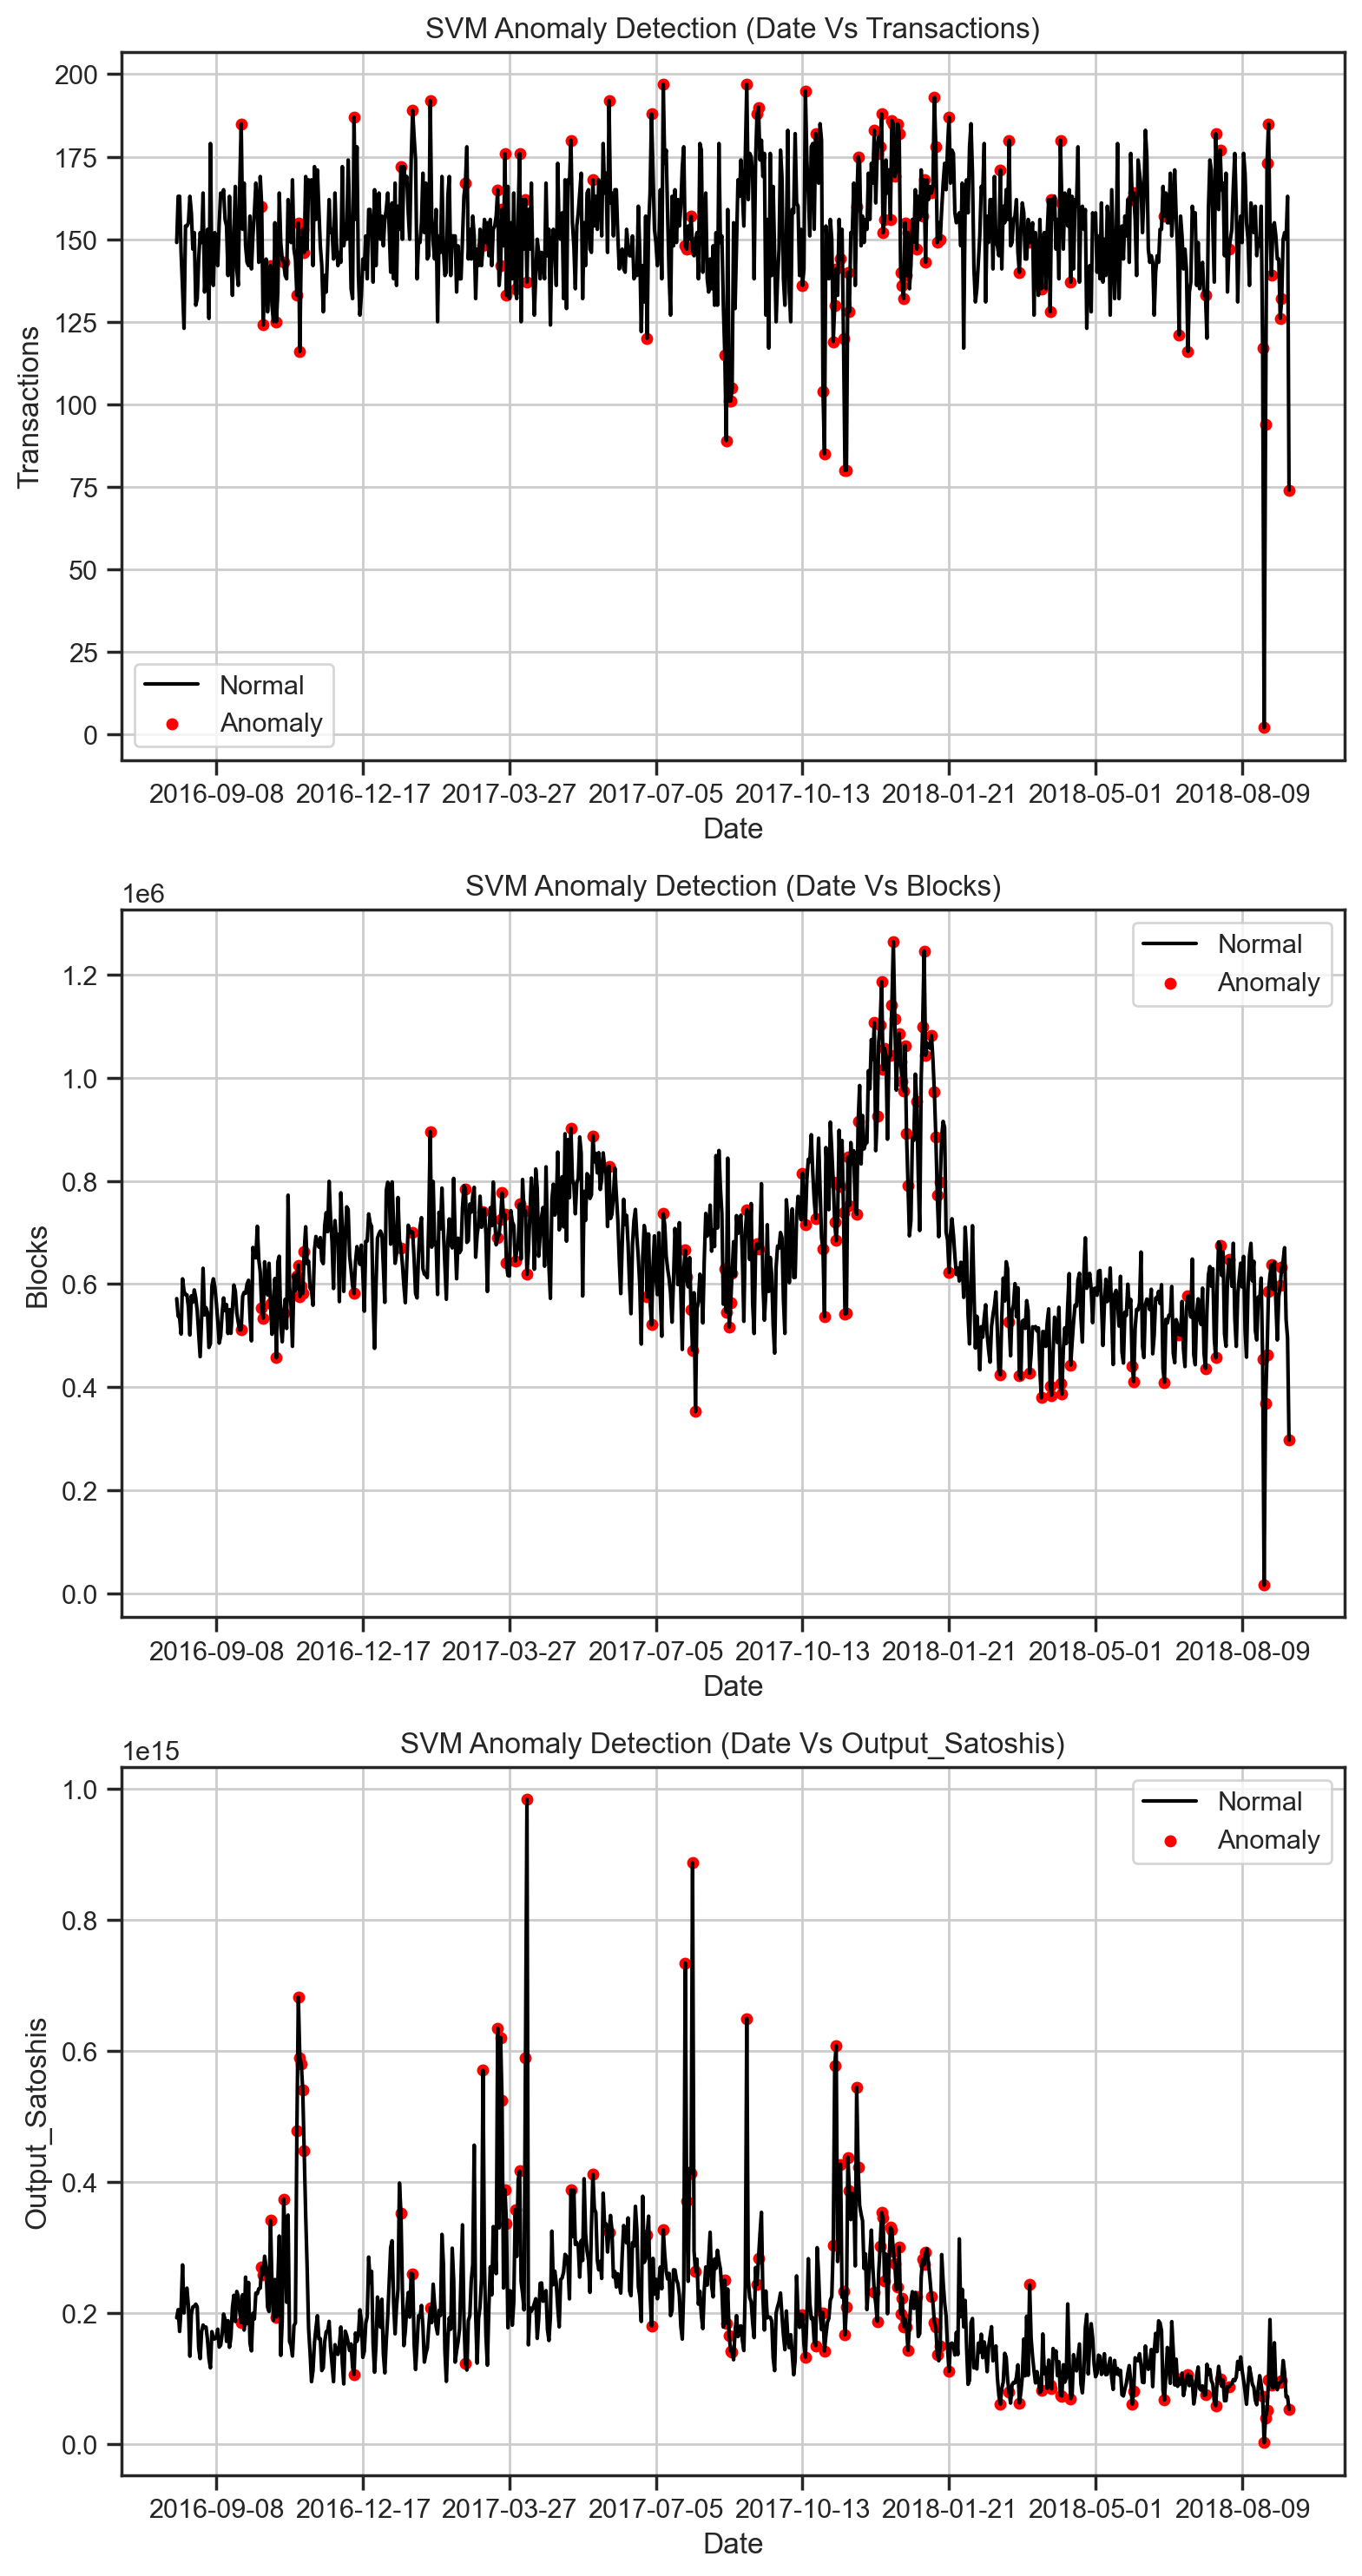

In [46]:
# Convert 'Date' column to datetime format
finalDataset['Date'] = pd.to_datetime(finalDataset['Date'])

fig, ax = plt.subplots(3, 1, figsize=(8, 15))  # Adjust the figsize as needed

variables = ['Transactions', 'Blocks', 'Output_Satoshis']

for i, variable in enumerate(variables):
    a = finalDataset.loc[finalDataset['anomaly_SVM'] == 1]
    ax[i].plot(finalDataset['Date'], finalDataset[variable], color='black', label='Normal', linewidth=1.5)
    ax[i].scatter(a['Date'], a[variable], color='red', label='Anomaly', s=16)
    ax[i].legend()
    ax[i].set_title("SVM Anomaly Detection (" + "Date Vs " + variable + ")")
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel(variable)
    ax[i].grid(True)
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the x-axis as 'YYYY-MM-DD'
    ax[i].xaxis.set_major_locator(mdates.DayLocator(interval=100))  

plt.tight_layout()
plt.savefig('svm_anomalies.png')
plt.show()

In [47]:
finalDataset['anomaly_SVM'].value_counts()

0    642
1    118
Name: anomaly_SVM, dtype: int64

## Performance 

In [48]:
# select the cases for final anomaly in which both the algorithms predicted anomaly
final_anomaly = finalDataset[
    (finalDataset['anomaly_kmeans'] == 1) &
    (finalDataset['anomaly_IsolationForest'] == 1) &
    (finalDataset['anomaly_autoencoder'] == 1) &
    (finalDataset['anomaly_gaussian_Mixture'] == 1) & 
    (finalDataset['anomaly_SVM'] == 1)
]

final_anomaly                             

Date  Transactions   Blocks  Output_Satoshis  \
121 2016-12-11           187   581600  106066365452387   
239 2017-04-08           137   618774  983813684090639   
324 2017-07-02           188   520931  179963214846133   
352 2017-07-30           147   471696  886622252448205   
375 2017-08-22            89   545685  184321752772626   
377 2017-08-24           101   516578  164868654018430   
429 2017-10-15           195   715357  132466396362477   
442 2017-10-28            85   536785  141769581194228   
456 2017-11-11            80   542026  166488036971292   
457 2017-11-12            80   542990  208793062714549   
481 2017-12-06           188  1187481  353151098127536   
488 2017-12-13           186  1142229  326755070839996   
489 2017-12-14           185  1264802  294354264672696   
510 2018-01-04           168  1246924  273782546133884   
527 2018-01-21           187   622701  110852507146823   
568 2018-03-03           180   526099   78972428937334   
590 2018-03-25           135   379374   81475622499820   
596 2018-03-31           128   402851   89888956327410   
603 2018-04-07           180   407376   74382847396091   
604 2018-04-08           161   386145   73197543059864   
709 2018-07-22           182   456925   58308816875623   
741 2018-08-23           117   453793   72669855481938   
743 2018-08-25            94   368325   40116427500609   
744 2018-08-26           173   463319   51550831192980   
745 2018-08-27           185   585010   97440777346653   
759 2018-09-10            74   297030   52652140145801   

     anomaly_IsolationForest  anomaly_kmeans  anomaly_autoencoder  \
121                        1               1                    1   
239                        1               1                    1   
324                        1               1                    1   
352                        1               1                    1   
375                        1               1                    1   
377                        1               1                    1   
429                        1               1                    1   
442                        1               1                    1   
456                        1               1                    1   
457                        1               1                    1   
481                        1               1                    1   
488                        1               1                    1   
489                        1               1                    1   
510                        1               1                    1   
527                        1               1                    1   
568                        1               1                    1   
590                        1               1                    1   
596                        1               1                    1   
603                        1               1                    1   
604                        1               1                    1   
709                        1               1                    1   
741                        1               1                    1   
743                        1               1                    1   
744                        1               1                    1   
745                        1               1                    1   
759                        1               1                    1   

     anomaly_gaussian_Mixture  anomaly_SVM  
121                         1            1  
239                         1            1  
324                         1            1  
352                         1            1  
375                         1            1  
377                         1            1  
429                         1            1  
442                         1            1  
456                         1            1  
457                         1            1  
481                         1            1  
488                         1          

In [49]:
# Select the cases in which either of the two algorithms predicted anomaly
possible_anomaly = finalDataset[
    (finalDataset['anomaly_kmeans'] == 1) |
    (finalDataset['anomaly_IsolationForest'] == 1) |
    (finalDataset['anomaly_autoencoder'] == 1) |
    (finalDataset['anomaly_gaussian_Mixture'] == 1) | 
    (finalDataset['anomaly_SVM'] == 1)
]

possible_anomaly

Date  Transactions  Blocks  Output_Satoshis  \
9   2016-08-21           163  501182  133890957673910   
22  2016-09-03           126  476950  130842492080702   
23  2016-09-04           179  484399  116063275421504   
43  2016-09-24           166  510540  201918495092598   
44  2016-09-25           185  511970  185182656692238   
..         ...           ...     ...              ...   
753 2018-09-04           126  596961   93682826664435   
754 2018-09-05           132  633097   96301047581806   
757 2018-09-08           150  531346   71886241720552   
758 2018-09-09           163  495661   72006661552204   
759 2018-09-10            74  297030   52652140145801   

     anomaly_IsolationForest  anomaly_kmeans  anomaly_autoencoder  \
9                          0               1                    0   
22                         0               0                    0   
23                         0               1                    1   
43                         0               0                    0   
44                         1               0                    1   
..                       ...             ...                  ...   
753                        0               0                    0   
754                        0               0                    0   
757                        0               1                    0   
758                        0               1                    1   
759                        1               1                    1   

     anomaly_gaussian_Mixture  anomaly_SVM  
9                           0            0  
22                          1            0  
23                          1            0  
43                          1            0  
44                          1            1  
..                        ...          ...  
753                         1            1  
754                         1            1  
757                         0            0  
758                         0            0  
759                         1            1  

[289 rows x 9 columns]

In [50]:
no_anomaly = finalDataset[
    (finalDataset['anomaly_kmeans'] == 0) &
    (finalDataset['anomaly_IsolationForest'] == 0) &
    (finalDataset['anomaly_autoencoder'] == 0) &
    (finalDataset['anomaly_gaussian_Mixture'] == 0) & 
    (finalDataset['anomaly_SVM'] == 0)
]
no_anomaly

Date  Transactions  Blocks  Output_Satoshis  \
0   2016-08-12           149  571788  192449213278677   
1   2016-08-13           163  537632  204909291864336   
2   2016-08-14           163  533825  171656943644686   
3   2016-08-15           146  502906  207713022974418   
4   2016-08-16           135  610164  273195830621631   
..         ...           ...     ...              ...   
749 2018-08-31           155  642507  154368852643687   
751 2018-09-02           144  491490   82763013809598   
752 2018-09-03           144  575316   92460063591992   
755 2018-09-06           150  645864  127295710140994   
756 2018-09-07           152  670653  108604821016277   

     anomaly_IsolationForest  anomaly_kmeans  anomaly_autoencoder  \
0                          0               0                    0   
1                          0               0                    0   
2                          0               0                    0   
3                          0               0                    0   
4                          0               0                    0   
..                       ...             ...                  ...   
749                        0               0                    0   
751                        0               0                    0   
752                        0               0                    0   
755                        0               0                    0   
756                        0               0                    0   

     anomaly_gaussian_Mixture  anomaly_SVM  
0                           0            0  
1                           0            0  
2                           0            0  
3                           0            0  
4                           0            0  
..                        ...          ...  
749                         0            0  
751                         0            0  
752                         0            0  
755                         0            0  
756                         0            0  

[471 rows x 9 columns]

In [51]:
total_anomaly = len(final_anomaly)+len(possible_anomaly)
percent_total_anomaly = total_anomaly*100/len(finalDataset)
print('Total records:',len(finalDataset))
print('Number of final anomaly:', len(final_anomaly))
print('Number of possible anomaly:', len(possible_anomaly))
print('Total anomaly:', total_anomaly)
print('Percentage of total anomaly in the data: %0.2f' % percent_total_anomaly)

Total records: 760
Number of final anomaly: 26
Number of possible anomaly: 289
Total anomaly: 315
Percentage of total anomaly in the data: 41.45
